In [1]:
#!conda install -c conda-forge statsmodels -y

#!conda install pandas numpy matplotlib scikit-learn seaborn -y

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import tensorflow as tf

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_val_score, train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score)
from sklearn.feature_selection import RFECV, mutual_info_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from scikeras.wrappers import KerasClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding
from tensorflow.keras.utils import to_categorical


from statsmodels.tsa.stattools import adfuller

In [2]:
#Importing Data
data = pd.read_csv("data/ACLED2021-2024.csv")


data.drop(columns=['time_precision', 'assoc_actor_1', 'assoc_actor_2', 'iso', 'region', 'admin3', 'location', 
                  'latitude', 'longitude', 'geo_precision', 'source_scale', 'timestamp', 'tags', 'population_best', 'event_id_cnty'], 
          inplace=True)
print(data.shape)


data['event_date'] = pd.to_datetime(data['event_date'], errors = 'coerce') #changing to datetime
#data.set_index('event_date', inplace=True)
#data.index = pd.to_datetime(data.index)
data.sort_index(inplace=True)

print(data.shape)
#data = data.dropna(subset=['event_date'])

(38130, 17)
(38130, 17)


38130 rows × 32 columns - Original Dataset Dimensions

In [3]:
# Dropping Dupes
initial_row_count = data.shape[0]
data = data.drop_duplicates()
final_row_count = data.shape[0]
print(f"Removed {initial_row_count - final_row_count} duplicates")
print(data.shape)

Removed 40 duplicates
(38090, 17)


In [4]:
#Reformatting / Cleaning

#Addressing NA values - Categorical, NUmerical and date
categorical_columns = ['disorder_type', 'event_type', 'sub_event_type', 'actor1', 'actor2', 'civilian_targeting', 
                       'country', 'admin1', 'admin2', 'source', 'notes']
categorical_columns = data[categorical_columns]


for column in categorical_columns:
    data[column] = data[column].fillna('Not specified')

numerical_columns = ['fatalities', 'inter1', 'inter2', 'interaction']

for column in numerical_columns:
    data[column] = data[column].fillna(data[column].median()) #using median to fill
    
print(data.isna().sum())
print(data.shape)
#data.loc[:, 'actor2'] = data['actor2'].fillna('Not specified')
#data.loc[:, 'civilian_targeting'] = data['civilian_targeting'].fillna('Not specified')

event_date            0
year                  0
disorder_type         0
event_type            0
sub_event_type        0
actor1                0
inter1                0
actor2                0
inter2                0
interaction           0
civilian_targeting    0
country               0
admin1                0
admin2                0
source                0
notes                 0
fatalities            0
dtype: int64
(38090, 17)


In [5]:
data

,event_date,year,disorder_type,event_type,sub_event_type,actor1,inter1,actor2,inter2,interaction,civilian_targeting,country,admin1,admin2,source,notes,fatalities
0,2024-04-19,2024,Political violence,Explosions/Remote violence,Shelling/artillery/missile attack,Hamas Movement,3,Not specified,0,30,Not specified,Israel,HaDarom,Ashqelon,N12; Times of Israel,"Interception: On 19 April 2024, Hamas militant...",0
1,2024-04-19,2024,Demonstrations,Protests,Peaceful protest,Protesters (Israel),6,Not specified,0,60,Not specified,Israel,Haifa,Hadera,Ynet,"On 19 April 2024, thousands formed a human cha...",0
2,2024-04-19,2024,Demonstrations,Riots,Violent demonstration,Rioters (Israel),5,Rioters (Israel),5,55,Not specified,Israel,HaMerkaz,Ramla,Haaretz; Jerusalem Post; N12; Times of Israel;...,"On 19 April 2024, dozens of relatives of hosta...",0
3,2024-04-19,2024,Demonstrations,Protests,Peaceful protest,Protesters (Israel),6,Not specified,0,60,Not specified,Israel,HaMerkaz,Rehovot,Ynet,"On 19 April 2024, thousands formed a human cha...",0
4,2024-04-19,2024,Political violence,Battles,Armed clash,Hezbollah,3,Military Forces of Israel (2022-),1,13,Not specified,Israel,HaZafon,Zefat,Jerusalem Post; Ma'ariv; Times of Israel,"On 19 April 2024, Hezbollah forces in Lebanon ...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38125,2021-04-20,2021,Strategic developments,Strategic developments,Other,Military Forces of Israel (2009-2021),8,Civilians (Palestine),7,78,Not specified,Palestine,Gaza Strip,North Gaza,PLO Negotiations Affairs Department,"Other: On 20 April 2021, Israeli military forc...",0
38126,2021-04-20,2021,Political violence,Riots,Mob violence,Rioters (Israel),5,Not specified,0,50,Not specified,Palestine,West Bank,Hebron,PLO Negotiations Affairs Department,"On 20 April 2021, Israeli settlers uprooted 20...",0
38127,2021-04-20,2021,Demonstrations,Protests,Peaceful protest,Protesters (Palestine),6,Not specified,0,60,Not specified,Palestine,Gaza Strip,Deir El Balah,Ma'an News Agency,"On 20 April 2021, a large protest organized by...",0
38128,2021-04-20,2021,Political violence,Riots,Mob violence,Rioters (Israel),5,Civilians (Palestine),7,57,Civilian targeting,Palestine,West Bank,Ramallah and Al Bireh,PLO Negotiations Affairs Department,"On 20 April 2021, Israeli settlers from the Ba...",0


In [6]:
#Grouping Together Actor1 and 2
def consolidate_names(name):
    if 'Military Forces of Israel' in name:
        return 'Military Forces of Israel'
    elif 'Police Forces of Israel' in name:
        return 'Police Forces of Israel'
    elif 'Hamas Movement' in name:
        return 'Hamas Movement'
    elif 'Police Forces of Israel' in name or 'Government of Israel' in name:
        return 'Government and Police Forces of Israel'
    elif 'Police Forces of Palestine' in name or 'Government of Palestine' in name:
        return 'Government and Police Forces of Palestine'
    elif 'PIJ:' in name or 'Islamic Jihad' in name:
        return 'Palestinian Islamic Jihad'
    elif 'Hezbollah' in name:
        return 'Hezbollah'
    elif 'Al Aqsa' in name:
        return 'Al Aqsa Martyrs Brigade'
    elif 'Katibat' in name:
        return 'Katibat Groups (Palestine)'
    elif 'PFLP:' in name:
        return 'Popular Front for the Liberation of Palestine'
    elif 'DFLP:' in name:
        return 'Democratic Front for the Liberation of Palestine'
    elif 'Military Forces of Iran' in name:
        return 'Iranian Revolutionary Guard Corps'
    elif 'Islamic State' in name:
        return 'Islamic State'
#civilians
    elif 'Civilians' in name:
        if 'Israel' in name or 'Palestine' in name:
            return name  #Keeping isr and pal civilians
        else:
            return 'Civilians (International)'  # grouping others as int.
#armed groups
    elif 'Unidentified Armed Group' in name:
        if 'Israel' in name or 'Palestine' in name:
            return name  
        else:
            return 'Unidentified Armed Group (International)'
#military forces
    elif 'Military Forces of' in name:
        if 'Israel' in name or 'Palestine' in name:
            return name  
        else:
            return 'Military Forces of International Forces'
    elif 'Settlers' in name:
        return 'Settlers (Israel)'
    elif 'Protesters' in name or 'Rioters' in name:
        return name  # Retains specific categories due to their distinct contexts
    else:
        return name #'Other Groups' 

# Apply the consolidation function to both actor1 and actor2
data['actor1_grouped'] = data['actor1'].apply(consolidate_names)
data['actor2_grouped'] = data['actor2'].apply(consolidate_names)

In [7]:
#Grouping smaller entities
actor1_counts = data['actor1_grouped'].value_counts()
actor2_counts = data['actor2_grouped'].value_counts()

def consolidate_small_groups(name, counts): #Check if Isr or Pal if not 'name'
    if counts[name] < 10:
        if 'Israel' in name:
            return 'Other (Israel)'
        elif 'Palestine' in name:
            return 'Other (Palestine)'
        else:
            return'Other Group'
    else:
        # Return the name if the count is 10 or more
        return name

# Apply the consolidation function to both actor1_grouped and actor2_grouped
data['actor1_grouped'] = data['actor1_grouped'].apply(lambda x: consolidate_small_groups(x, actor1_counts))
data['actor2_grouped'] = data['actor2_grouped'].apply(lambda x: consolidate_small_groups(x, actor2_counts))


# Print the new value counts to confirm re-categorization
#print(data['actor1_grouped'].value_counts())
#print(data['actor2_grouped'].value_counts())

data['actor1'] = data['actor1_grouped']
data['actor2'] = data['actor2_grouped']

data.drop(['actor1_grouped', 'actor2_grouped'], axis=1, inplace=True)


In [8]:
print(data.isna().sum())


event_date            0
year                  0
disorder_type         0
event_type            0
sub_event_type        0
actor1                0
inter1                0
actor2                0
inter2                0
interaction           0
civilian_targeting    0
country               0
admin1                0
admin2                0
source                0
notes                 0
fatalities            0
dtype: int64


In [9]:
# Calculate the percentage of zero values per column
zero_counts = (data == 0).astype(int).sum(axis=0)
zero_percentage = 100 * zero_counts / len(data)

# Display columns with high percentages of zeros
print("Percentage of zeros in each column:")
print(zero_percentage[zero_percentage > 0])  # Adjust the threshold as necessary


Percentage of zeros in each column:
inter2        27.274875
fatalities    91.047519
dtype: float64


In [10]:
#Creating Temporal Features for T-S

#Date related
data['year'] = data['event_date'].dt.year
data['month'] = data['event_date'].dt.month
data['day'] = data['event_date'].dt.day
data['day_of_week'] = data['event_date'].dt.day_name()
data['days_since_start'] = (data['event_date'] - data['event_date'].min()).dt.days

# time since last event of the same type
data['time_since_last_event'] = data.groupby('event_type')['event_date'].diff().dt.days
#data['time_since_last_event'] = data.groupby('event_type').apply(lambda x: x.index.to_series().diff().dt.days).reset_index(level=0, drop=True)


# time since last disorder of the same type
data['time_since_last_disorder'] = data.groupby('disorder_type')['event_date'].diff().dt.days
#data['time_since_last_disorder'] = data.groupby('disorder_type').apply(lambda x: x.index.to_series().diff().dt.days).reset_index(level=0, drop=True)
#print(data[['time_since_last_event', 'time_since_last_disorder']].head())


# rolling avg for fatalities
data['rolling_avg_fatalities_7d'] = data.groupby(
    'event_type')['fatalities'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())


# cumulative counts of events and fatalities by specific features
data['cumulative_events'] = data.groupby(['event_type']).cumcount() + 1
data['cumulative_fatalities'] = data.groupby(['event_type'])['fatalities'].cumsum()

log_data = data.copy()


In [11]:
#Log transformations
log_columns = ['fatalities', 'cumulative_events', 'cumulative_fatalities', 'rolling_avg_fatalities_7d', 
               'time_since_last_event', 'time_since_last_disorder', 'days_since_start']
for col in log_columns:
    log_data['log_' + col] = np.log1p(log_data[col])

# Creating lagged features
for col in log_columns:
    log_col = 'log_' + col
    for lag in [1, 2, 3]:
        log_data[f'{log_col}_lag{lag}'] = log_data[log_col].shift(lag)

/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [12]:
log_data

,event_date,year,disorder_type,event_type,sub_event_type,actor1,inter1,actor2,inter2,interaction,...,log_rolling_avg_fatalities_7d_lag3,log_time_since_last_event_lag1,log_time_since_last_event_lag2,log_time_since_last_event_lag3,log_time_since_last_disorder_lag1,log_time_since_last_disorder_lag2,log_time_since_last_disorder_lag3,log_days_since_start_lag1,log_days_since_start_lag2,log_days_since_start_lag3
0,2024-04-19,2024,Political violence,Explosions/Remote violence,Shelling/artillery/missile attack,Hamas Movement,3,Not specified,0,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-04-19,2024,Demonstrations,Protests,Peaceful protest,Protesters (Israel),6,Not specified,0,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.999422,NaN,NaN
2,2024-04-19,2024,Demonstrations,Riots,Violent demonstration,Rioters (Israel),5,Rioters (Israel),5,55,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.999422,6.999422,NaN
3,2024-04-19,2024,Demonstrations,Protests,Peaceful protest,Protesters (Israel),6,Not specified,0,60,...,0.0,NaN,NaN,NaN,0.0,NaN,NaN,6.999422,6.999422,6.999422
4,2024-04-19,2024,Political violence,Battles,Armed clash,Hezbollah,3,Military Forces of Israel,1,13,...,0.0,0.0,NaN,NaN,0.0,0.0,NaN,6.999422,6.999422,6.999422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38125,2021-04-20,2021,Strategic developments,Strategic developments,Other,Military Forces of Israel,8,Civilians (Palestine),7,78,...,0.0,0.0,-inf,0.0,0.0,-inf,0.0,0.000000,0.000000,0.000000
38126,2021-04-20,2021,Political violence,Riots,Mob violence,Rioters (Israel),5,Not specified,0,50,...,0.0,0.0,0.0,-inf,0.0,0.0,-inf,0.000000,0.000000,0.000000
38127,2021-04-20,2021,Demonstrations,Protests,Peaceful protest,Protesters (Palestine),6,Not specified,0,60,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
38128,2021-04-20,2021,Political violence,Riots,Mob violence,Rioters (Israel),5,Civilians (Palestine),7,57,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000


In [13]:
#print(log_data)
print(log_data.isna().sum())

# percentage of zero values
zero_counts = (log_data == 0).astype(int).sum(axis=0)
zero_percentage = 100 * zero_counts / len(log_data)
print(zero_percentage[zero_percentage > 0])


event_date                              0
year                                    0
disorder_type                           0
event_type                              0
sub_event_type                          0
actor1                                  0
inter1                                  0
actor2                                  0
inter2                                  0
interaction                             0
civilian_targeting                      0
country                                 0
admin1                                  0
admin2                                  0
source                                  0
notes                                   0
fatalities                              0
month                                   0
day                                     0
day_of_week                             0
days_since_start                        0
time_since_last_event                   6
time_since_last_disorder                4
rolling_avg_fatalities_7d         

In [14]:
#Cleaning log data

#replacing infinities w NaN
log_data.replace([np.inf, -np.inf], np.nan, inplace=True)
#log_data.fillna(log_data.median(), inplace=True)

#median for numeric columns
numeric_medians = log_data.select_dtypes(include=[np.number]).median()
log_data.fillna(numeric_medians, inplace=True)


log_data['time_since_last_event'].fillna(method='ffill', inplace=True)
log_data['time_since_last_event'].fillna(method='bfill', inplace=True)

lag_cols = [col for col in log_data.columns if ('log_time_since_last_event' in col or 'lag' in col) and 
            np.issubdtype(log_data[col].dtype, np.number)]

#for col in lag_cols:
    # method can be ffill, bfill
    #log_data[col] = log_data[col].interpolate(method='bfill')

In [15]:
print(log_data.shape)
print(log_data.isna().sum())

# percentage of zero values
zero_counts = (log_data == 0).astype(int).sum(axis=0)
zero_percentage = 100 * zero_counts / len(log_data)
print(zero_percentage[zero_percentage > 0])

(38090, 54)
event_date                            0
year                                  0
disorder_type                         0
event_type                            0
sub_event_type                        0
actor1                                0
inter1                                0
actor2                                0
inter2                                0
interaction                           0
civilian_targeting                    0
country                               0
admin1                                0
admin2                                0
source                                0
notes                                 0
fatalities                            0
month                                 0
day                                   0
day_of_week                           0
days_since_start                      0
time_since_last_event                 0
time_since_last_disorder              0
rolling_avg_fatalities_7d             0
cumulative_events           

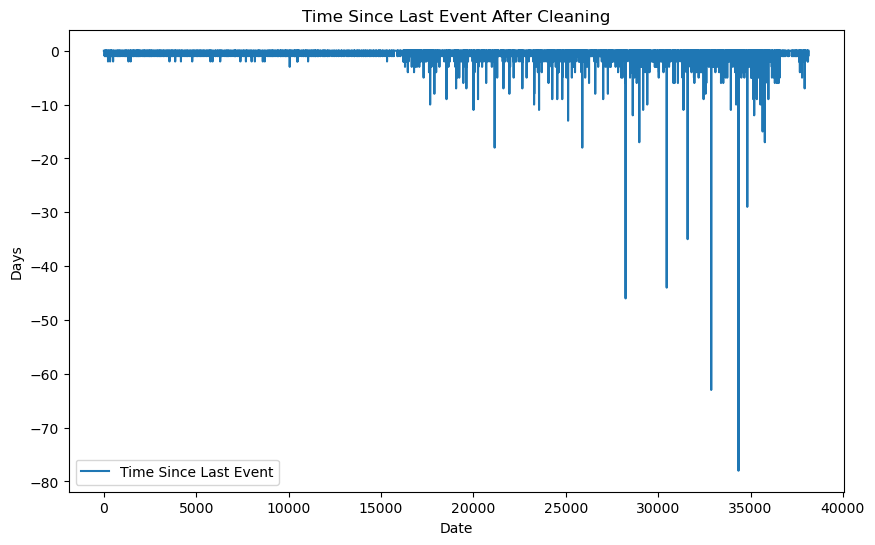

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(log_data['time_since_last_event'], label='Time Since Last Event')
plt.title('Time Since Last Event After Cleaning')
plt.xlabel('Date')
plt.ylabel('Days')
plt.legend()
plt.show()


In [17]:
#Encoding

#One-Hot for Categoricals
categorical_cols = ['disorder_type', 'event_type', 'actor1', 'actor2', 'civilian_targeting',
                    'country', 'admin1', 'admin2', 'day_of_week']
log_data_encoded = pd.get_dummies(log_data, columns=categorical_cols)
log_data_encoded

#Label Encoder
label_encoders = {}

for col in ['inter1', 'inter2', 'interaction', 'sub_event_type']:
    le = LabelEncoder()
    log_data_encoded[col] = le.fit_transform(log_data_encoded[col])
    label_encoders[col] = le  # storing the encoder
#print(log_data_encoded.isna().sum())
log_data_encoded.to_csv('data/log_data_encoded.csv', index=False)

In [18]:
log_data_encoded

,event_date,year,sub_event_type,inter1,inter2,interaction,source,notes,fatalities,month,...,admin2_Tulkarm,admin2_Yizreel,admin2_Zefat,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
0,2024-04-19,2024,18,2,0,9,N12; Times of Israel,"Interception: On 19 April 2024, Hamas militant...",0,4,...,False,False,False,True,False,False,False,False,False,False
1,2024-04-19,2024,15,5,0,21,Ynet,"On 19 April 2024, thousands formed a human cha...",0,4,...,False,False,False,True,False,False,False,False,False,False
2,2024-04-19,2024,19,4,4,17,Haaretz; Jerusalem Post; N12; Times of Israel;...,"On 19 April 2024, dozens of relatives of hosta...",0,4,...,False,False,False,True,False,False,False,False,False,False
3,2024-04-19,2024,15,5,0,21,Ynet,"On 19 April 2024, thousands formed a human cha...",0,4,...,False,False,False,True,False,False,False,False,False,False
4,2024-04-19,2024,3,2,1,3,Jerusalem Post; Ma'ariv; Times of Israel,"On 19 April 2024, Hezbollah forces in Lebanon ...",0,4,...,False,False,True,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38125,2021-04-20,2021,14,7,6,26,PLO Negotiations Affairs Department,"Other: On 20 April 2021, Israeli military forc...",0,4,...,False,False,False,False,False,False,False,False,True,False
38126,2021-04-20,2021,12,4,0,16,PLO Negotiations Affairs Department,"On 20 April 2021, Israeli settlers uprooted 20...",0,4,...,False,False,False,False,False,False,False,False,True,False
38127,2021-04-20,2021,15,5,0,21,Ma'an News Agency,"On 20 April 2021, a large protest organized by...",0,4,...,False,False,False,False,False,False,False,False,True,False
38128,2021-04-20,2021,12,4,6,19,PLO Negotiations Affairs Department,"On 20 April 2021, Israeli settlers from the Ba...",0,4,...,False,False,False,False,False,False,False,False,True,False


In [19]:
# Correlation Analysis for numerical cols
numerical_cols = log_data_encoded.select_dtypes(include=['int64', 'float64']).columns
numerical_data = log_data_encoded[numerical_cols]
correlation_matrix = numerical_data.corr()

threshold = 0.85
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool_))
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
to_drop

['interaction',
 'log_rolling_avg_fatalities_7d',
 'log_days_since_start',
 'log_days_since_start_lag1',
 'log_days_since_start_lag2',
 'log_days_since_start_lag3']

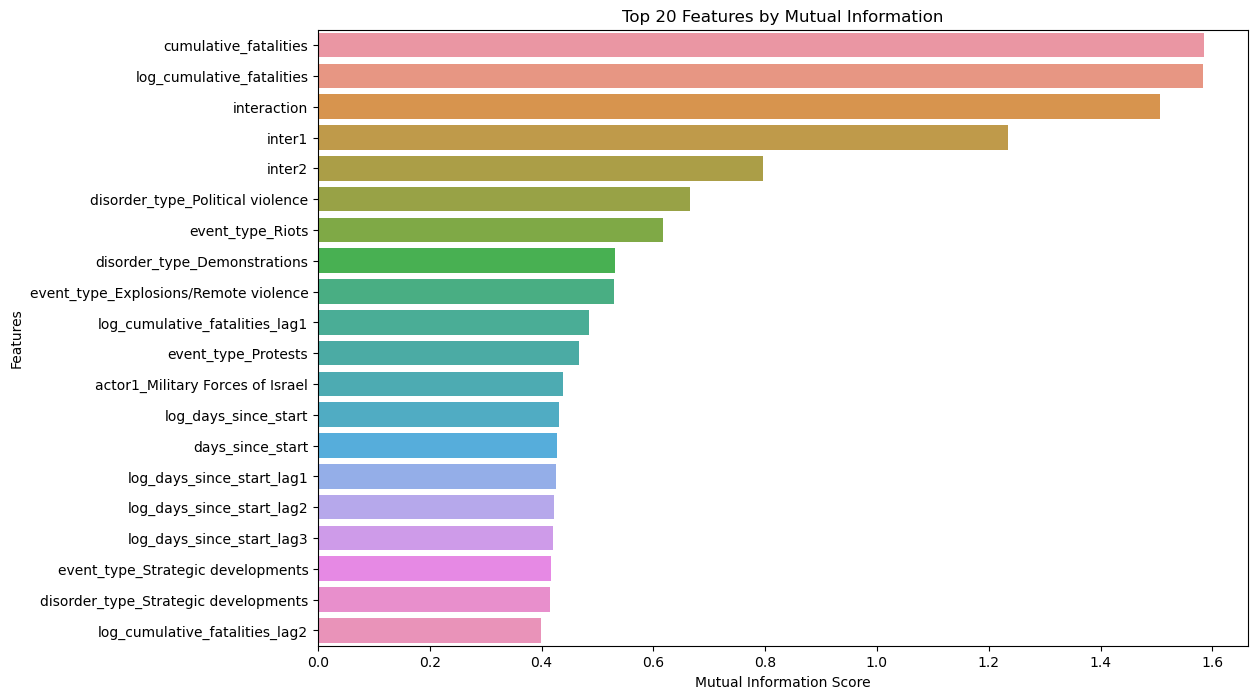

In [20]:
#Mututal Information features

target = 'sub_event_type'

# taking out the text + datetime
features = log_data_encoded.drop(columns=[target, 'event_date', 'source', 'notes'])

# actual mi score calculation
mi_scores = mutual_info_classif(features, log_data_encoded[target], discrete_features='auto')

# putting in df
mi_df = pd.DataFrame({'Feature': features.columns, 'MI_Score': mi_scores})
mi_df.sort_values('MI_Score', ascending=False, inplace=True)

plt.figure(figsize=(12, 8))
sns.barplot(x='MI_Score', y='Feature', data=mi_df.sort_values('MI_Score', ascending=False).head(20))
plt.title('Top 20 Features by Mutual Information')
plt.xlabel('Mutual Information Score')
plt.ylabel('Features')
plt.show()

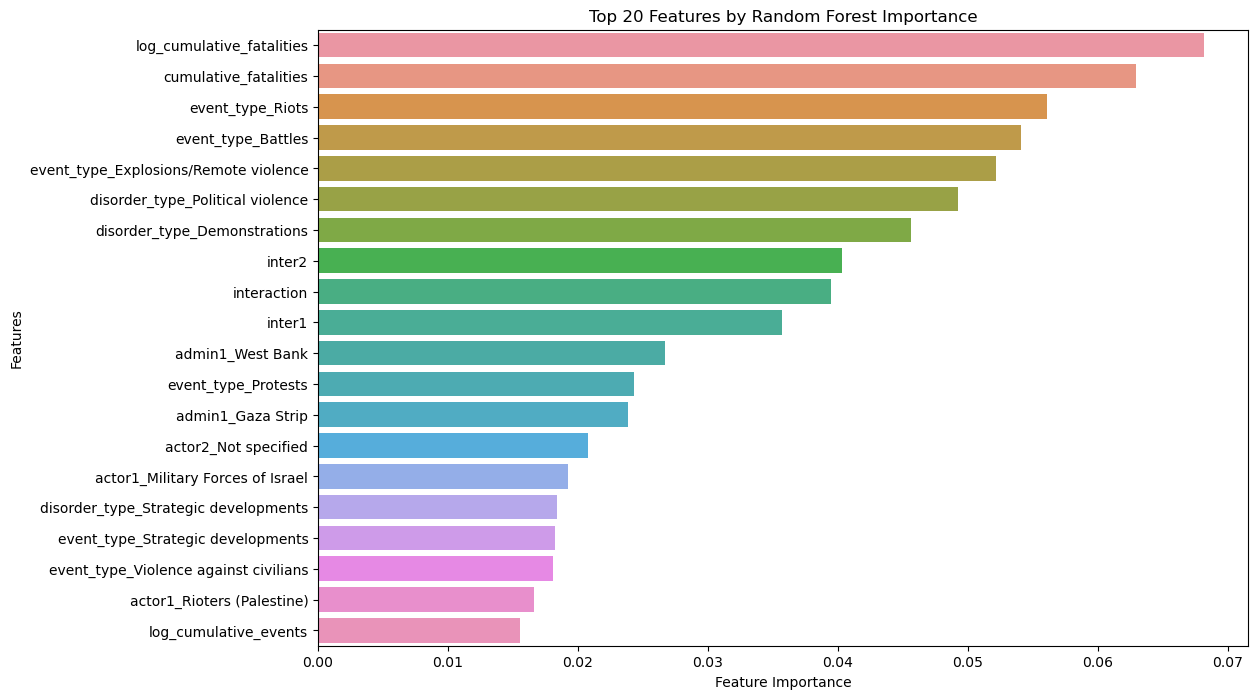

In [21]:
#Random Forest Importance
#numeric_encoded_log_data
#Dropping numeric + T/T Splitting
X = log_data_encoded.drop(['sub_event_type',  'event_date', 'source', 'notes'], axis=1)
y = log_data_encoded['sub_event_type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)

forest = RandomForestClassifier(random_state=42)
forest.fit(X_train, y_train)

# feature importances into df
importances = forest.feature_importances_

rf_df = pd.DataFrame({'Feature': X_train.columns, 'RF_Importance': importances})
rf_df.sort_values('RF_Importance', ascending=False, inplace=True)

plt.figure(figsize=(12, 8))
sns.barplot(x='RF_Importance', y='Feature', data=rf_df.sort_values('RF_Importance', ascending=False).head(20))
plt.title('Top 20 Features by Random Forest Importance')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.show()

In [22]:
print(mi_df.shape)
print(rf_df.shape)

(151, 2)
(151, 2)


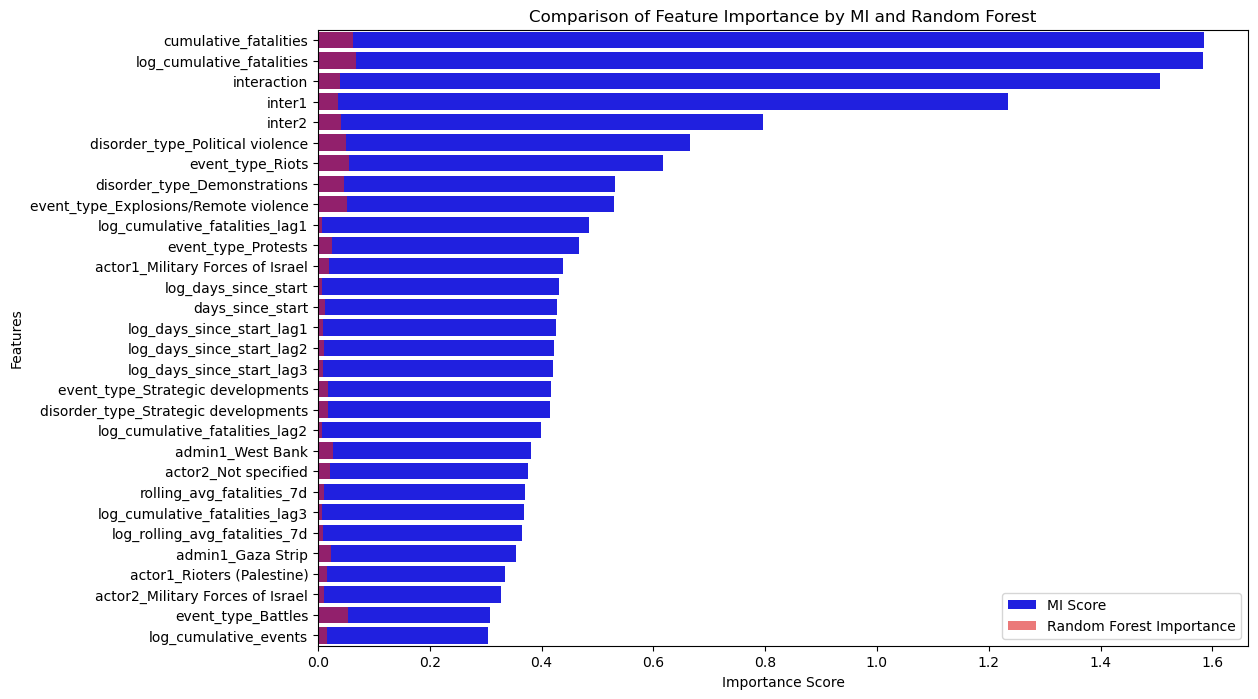

In [23]:
rf_df = pd.DataFrame({'Feature': X_train.columns,
                                    'RF_Importance': forest.feature_importances_})

#merging datasets
combined_importances = pd.merge(mi_df, rf_df, on='Feature', how='outer')

combined_importances.sort_values(by='MI_Score', ascending=False, inplace=True)

combined_importances = pd.merge(mi_df, rf_df, on='Feature', how='outer')

#set the amount of feaatures
sorted_idx = combined_importances.sort_values(by='MI_Score', ascending=False)['Feature'].head(30)


plt.figure(figsize=(12, 8))
sns.barplot(x='MI_Score', y='Feature', data=combined_importances[combined_importances['Feature'].isin(sorted_idx)], 
            color='blue', label='MI Score')
sns.barplot(x='RF_Importance', y='Feature', data=combined_importances[combined_importances['Feature'].isin(sorted_idx)], 
            color='red', alpha=0.6, label='Random Forest Importance')
plt.title('Comparison of Feature Importance by MI and Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.legend()
plt.show()


In [24]:
#setting arbitrary threshold to see the "small" values
test_thresh1 = 0.2
test_thresh2 = 0.01

#mi scores
low_mi_features = mi_df[mi_df['MI_Score'] <= test_thresh1]

#rf importances
low_rf_features = rf_df[rf_df['RF_Importance'] <= test_thresh2]

# intersection of low importance features from both
test_features = pd.merge(low_mi_features, low_rf_features, on='Feature', how='inner')

print(test_features)


                                         Feature  MI_Score  RF_Importance
0                              country_Palestine  0.190851       0.005839
1                     log_cumulative_events_lag3  0.182591       0.007163
2                     log_cumulative_events_lag2  0.173028       0.007326
3             log_rolling_avg_fatalities_7d_lag1  0.157955       0.004997
4                                           year  0.157102       0.001483
..                                           ...       ...            ...
109  actor2_Military Forces of Palestine (1994-)  0.000000       0.000035
110                        actor2_Other (Israel)  0.000000       0.000011
111                           actor2_Other Group  0.000000       0.000046
112                               admin2_Jericho  0.000000       0.000245
113                        day_of_week_Wednesday  0.000000       0.000877

[114 rows x 3 columns]


In [25]:
# MI score
mi_percentile = 70  # aka keeping top 50%
mi_threshold = np.percentile(mi_df['MI_Score'], mi_percentile)
#top_mi_features = mi_df[mi_df['MI_Score'] >= mi_threshold]
selected_mi_features = mi_df[mi_df['MI_Score'] >= mi_threshold]['Feature'].tolist()
#top_mi_features.shape
#print(selected_mi_features)

# random forest importance
rf_percentile = 70  # aka keeping top 50% | top 30% is 43 features
rf_threshold = np.percentile(rf_df['RF_Importance'], rf_percentile)
#top_rf_features = rf_df[rf_df['RF_Importance'] >= rf_threshold]
selected_rf_features = rf_df[rf_df['RF_Importance'] >= 
                                      rf_threshold]['Feature'].tolist()
#top_rf_features.shape
#print(selected_rf_features)

#Combining into 1
selected_features = list(set(selected_mi_features) & set(selected_rf_features))


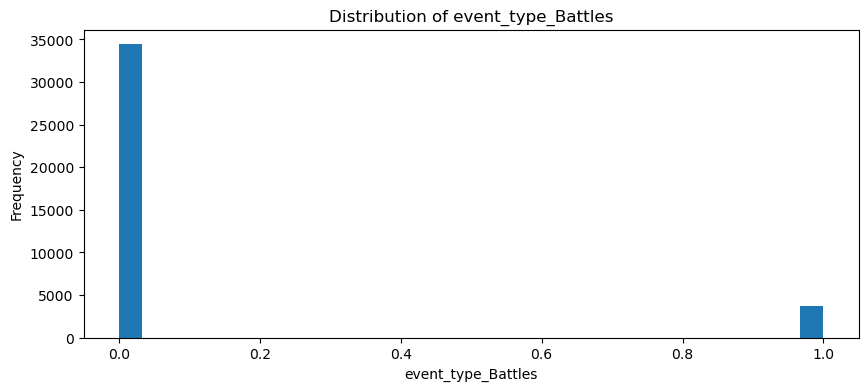

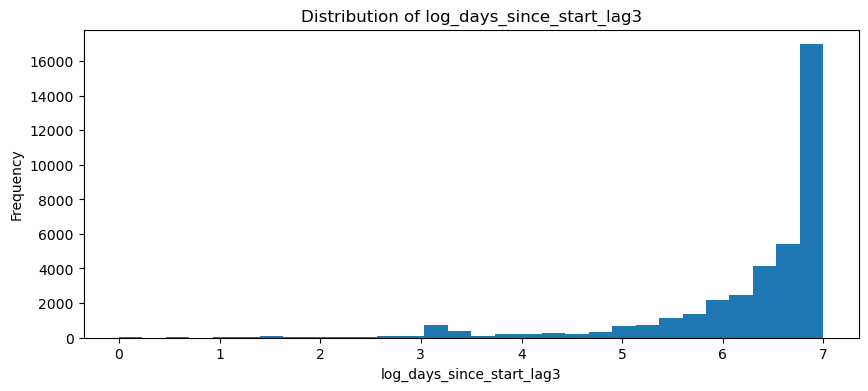

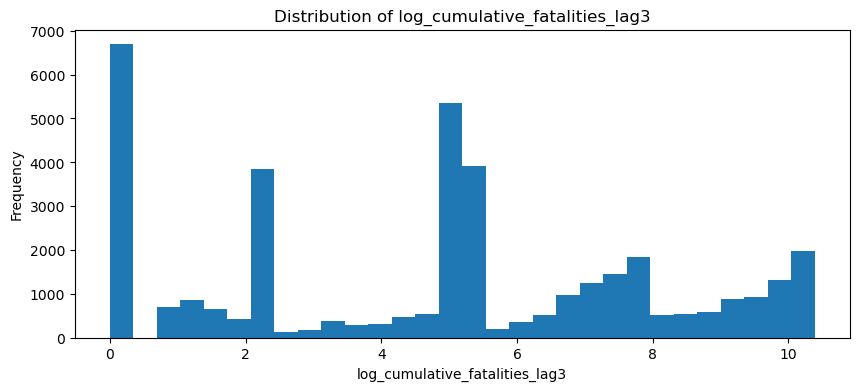

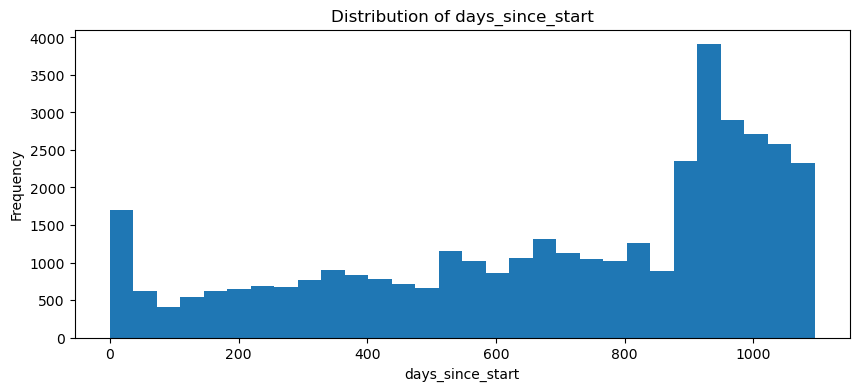

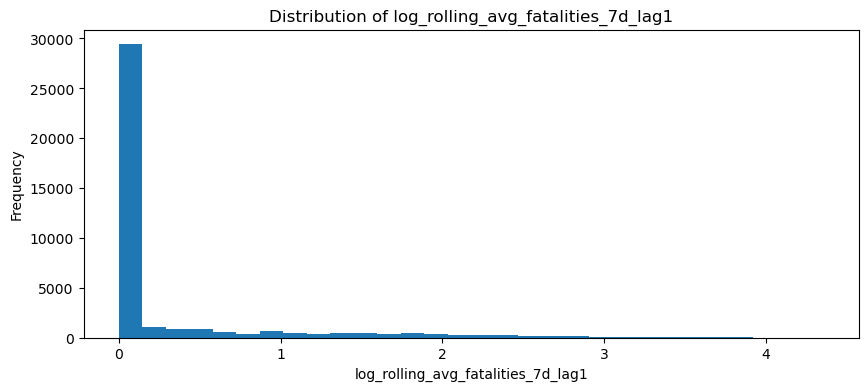

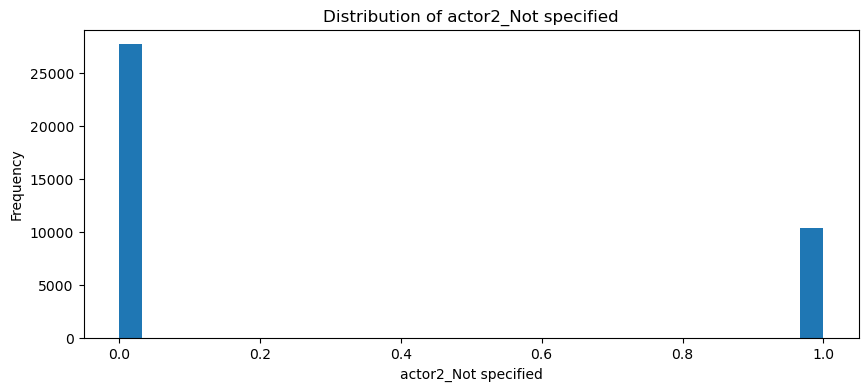

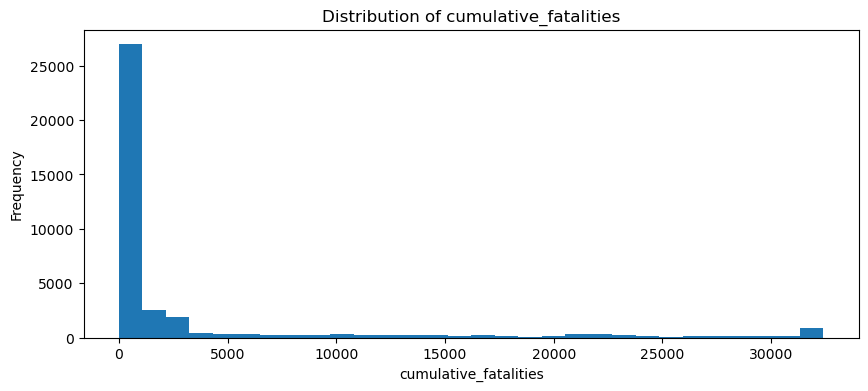

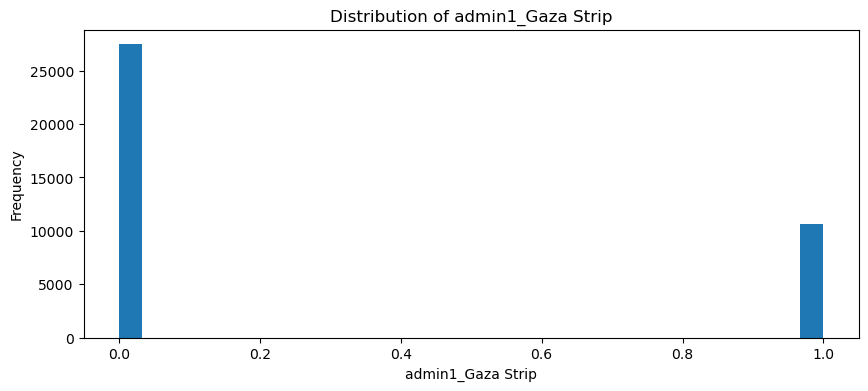

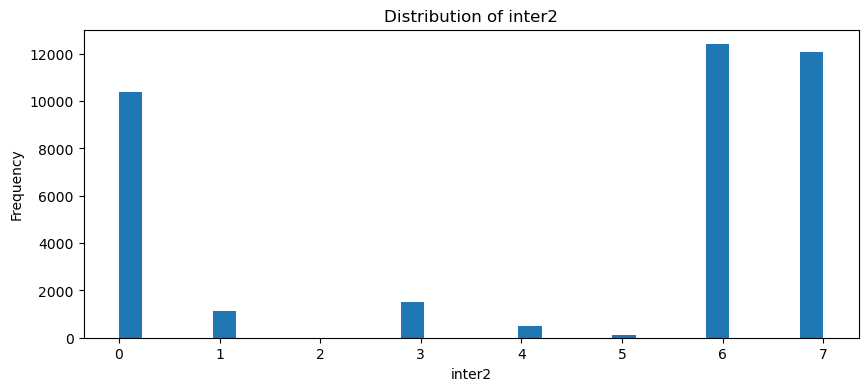

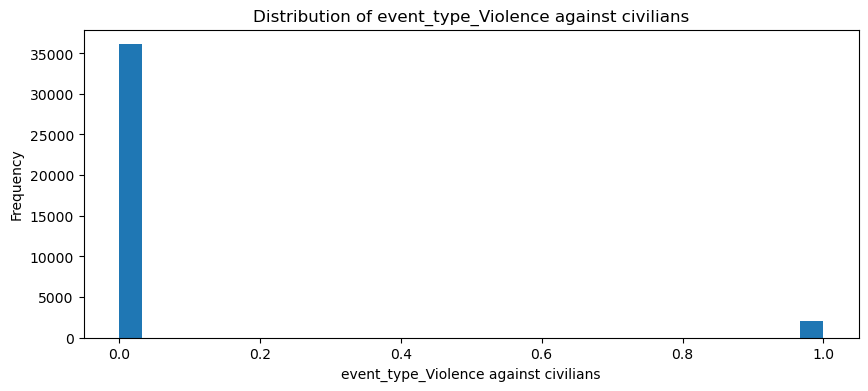

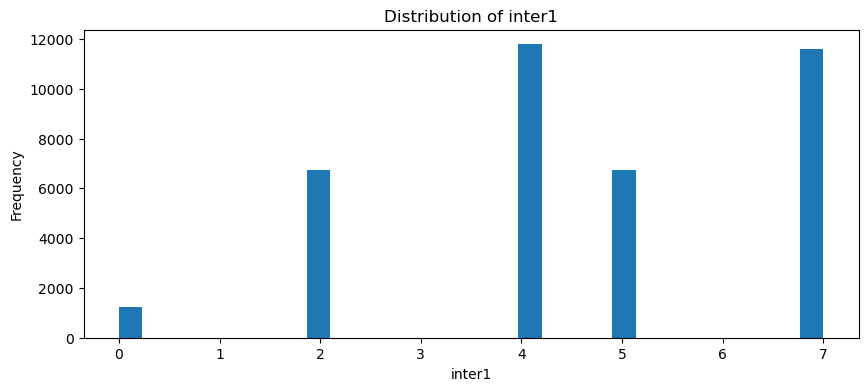

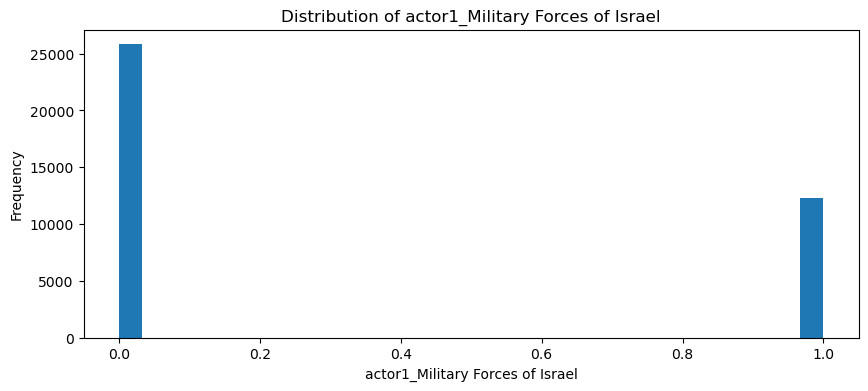

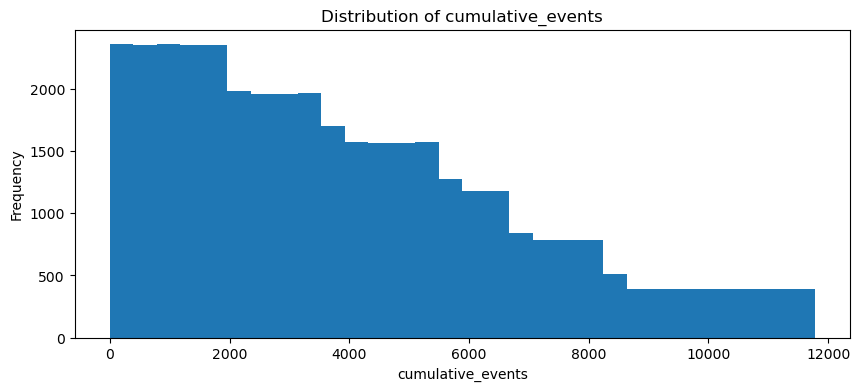

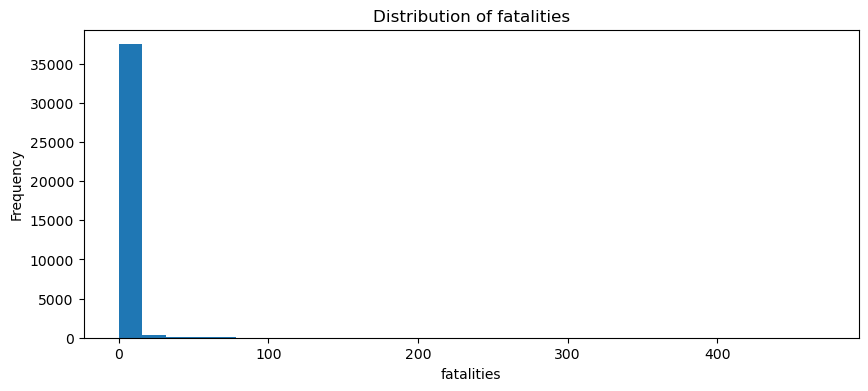

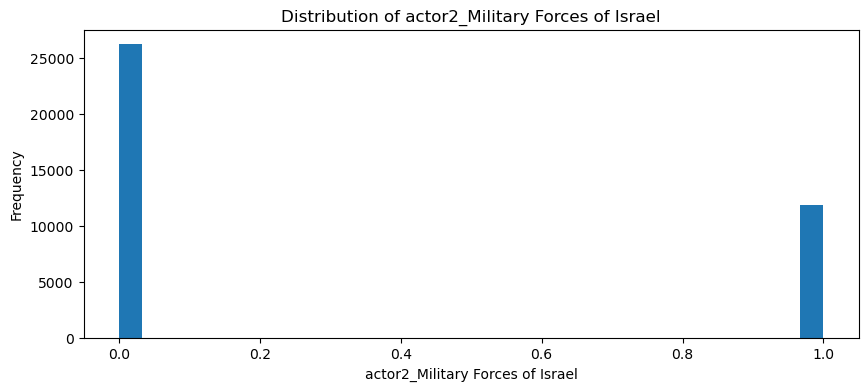

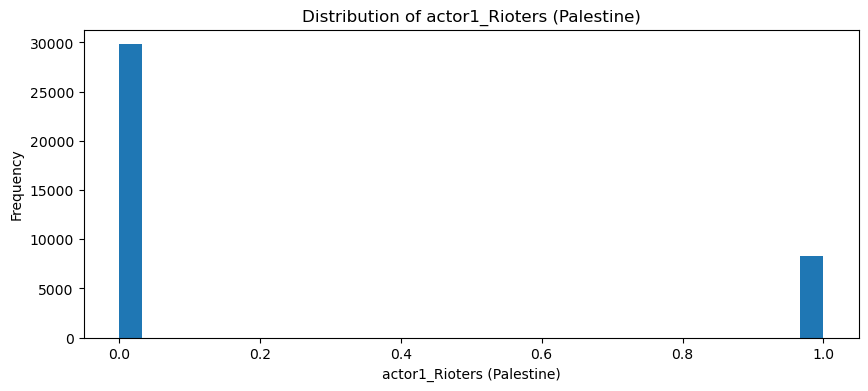

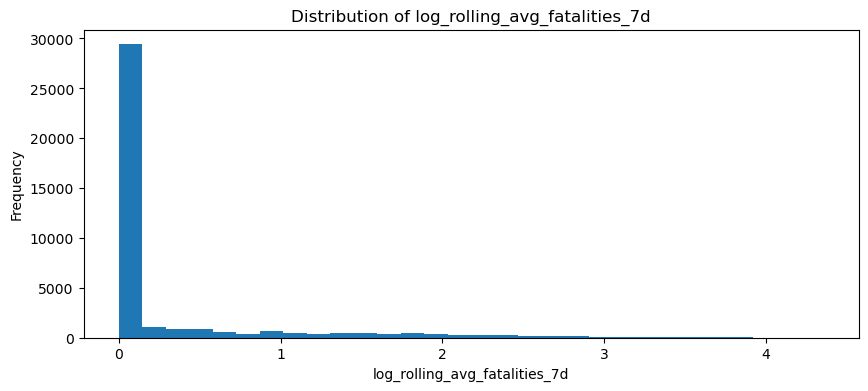

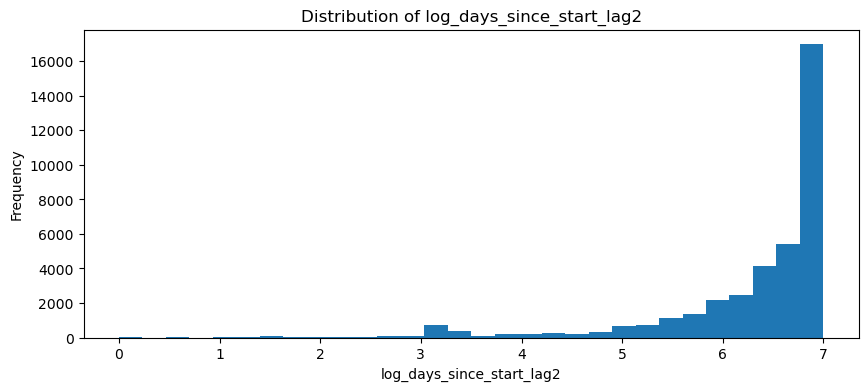

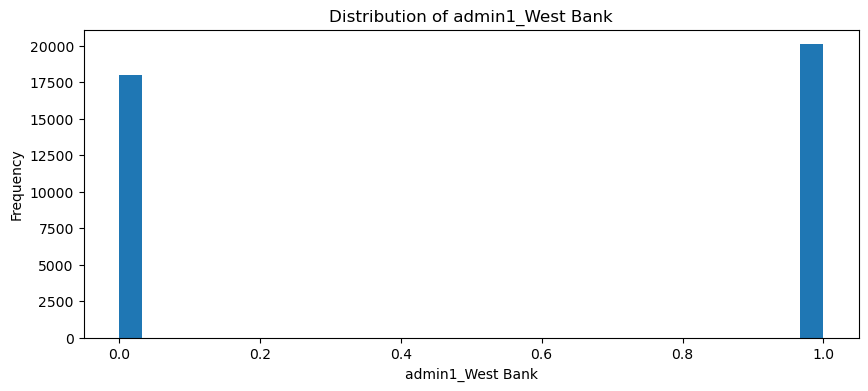

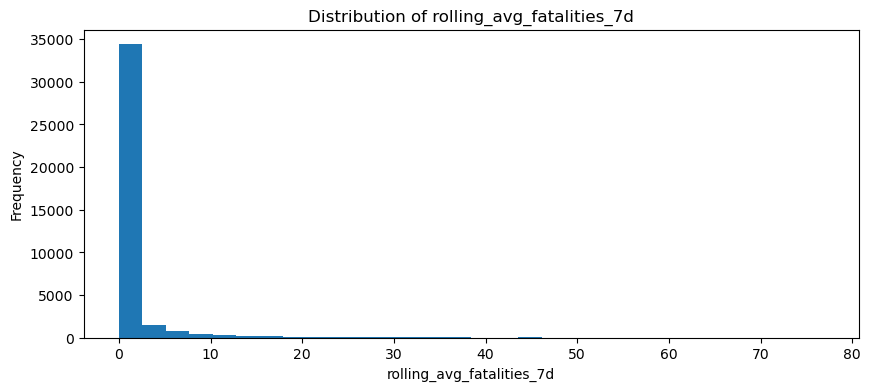

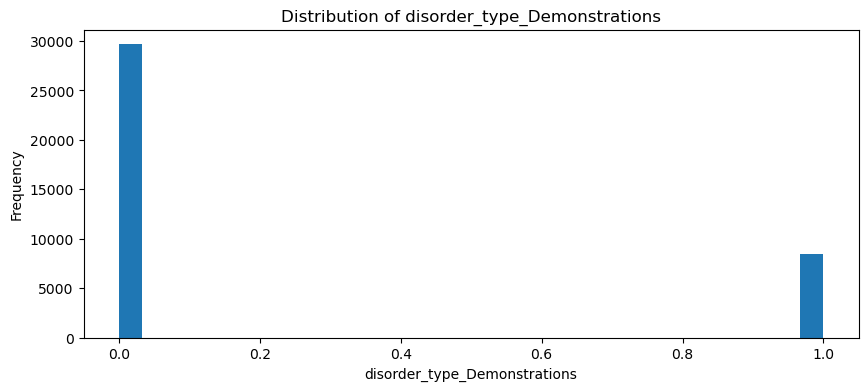

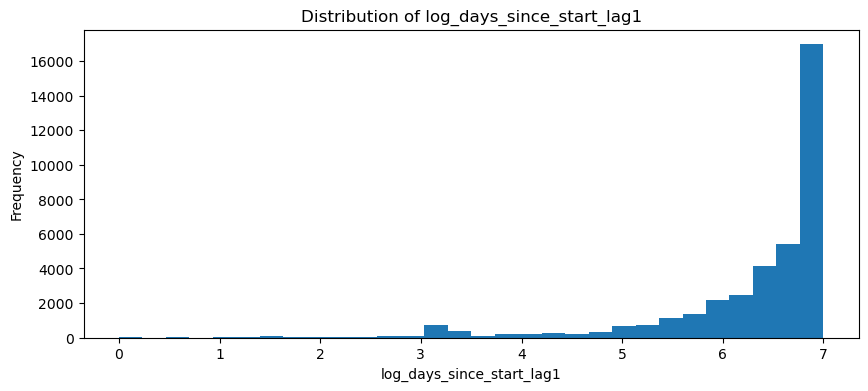

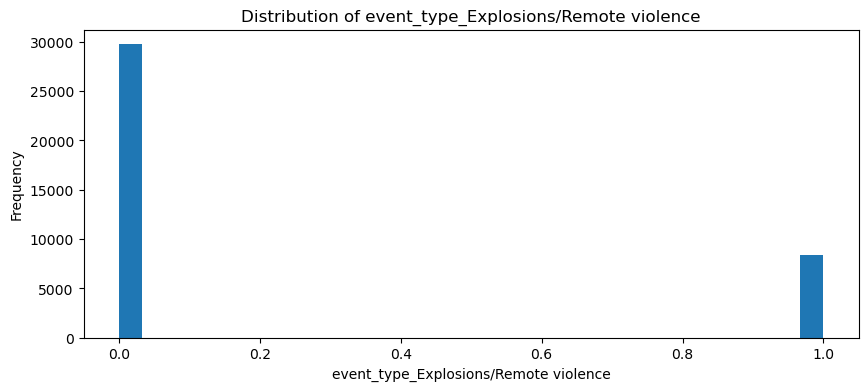

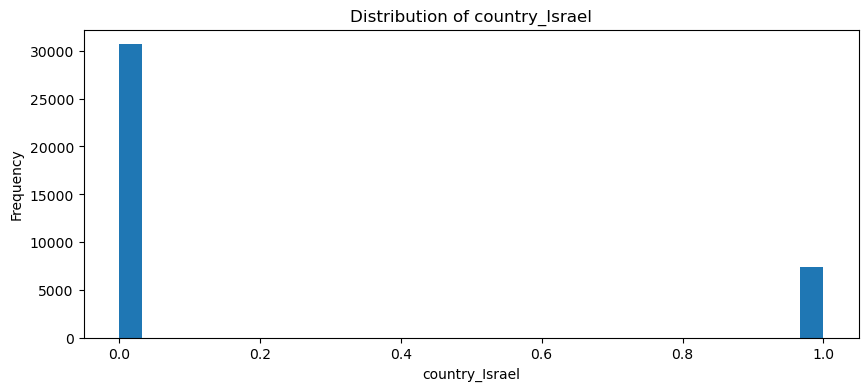

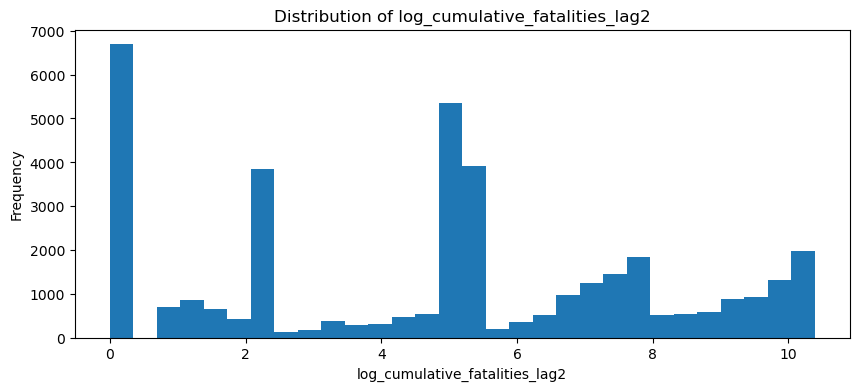

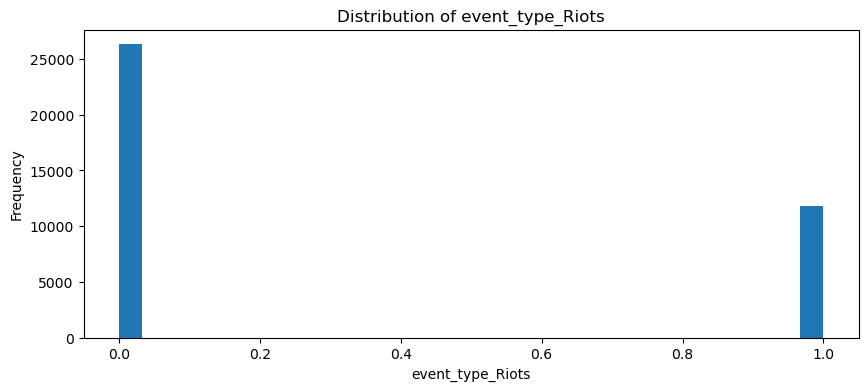

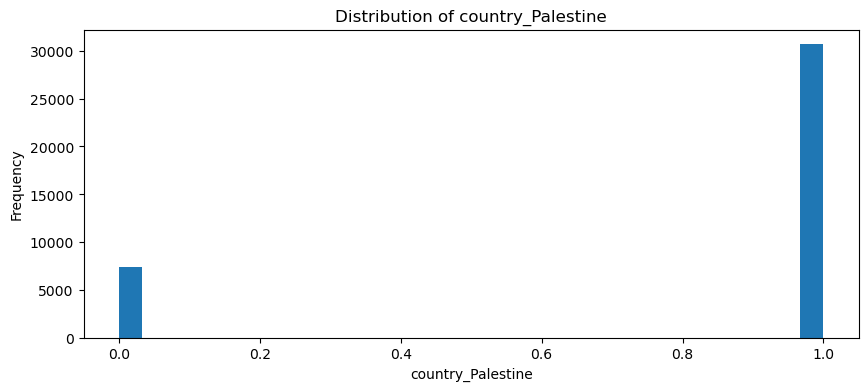

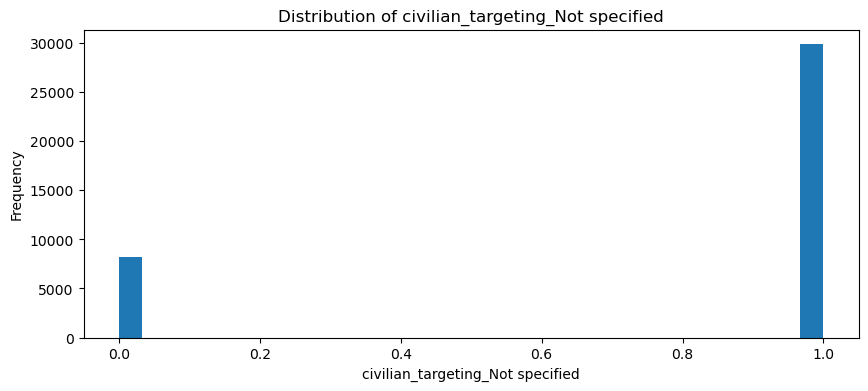

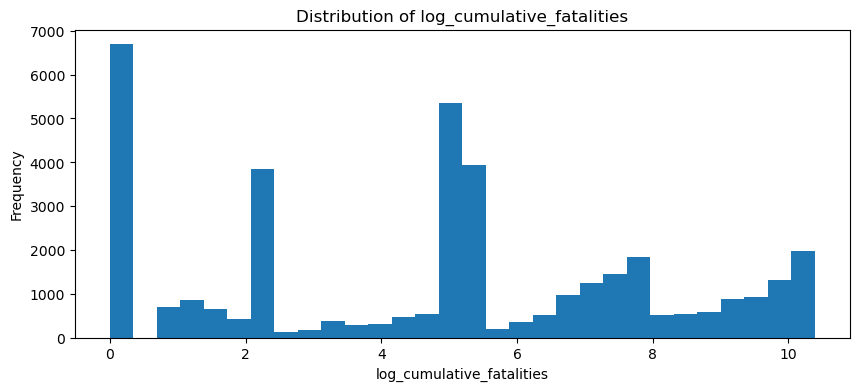

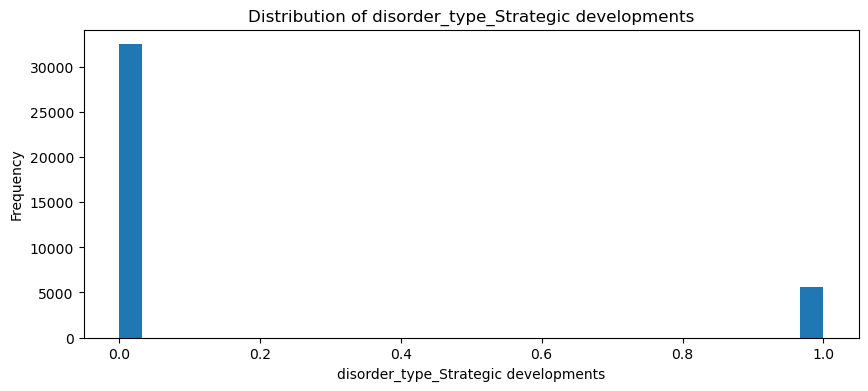

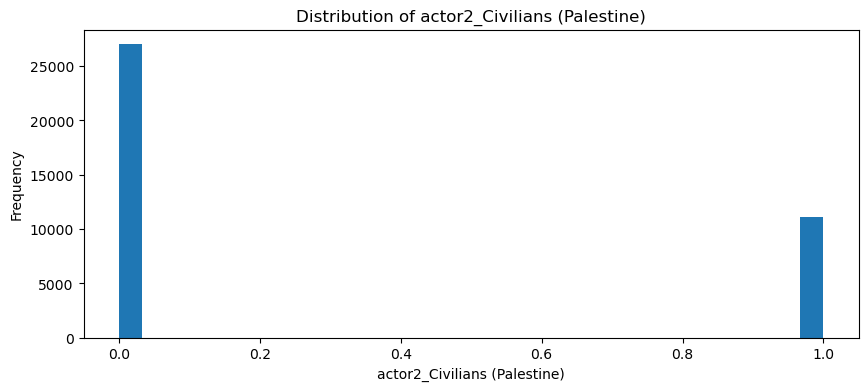

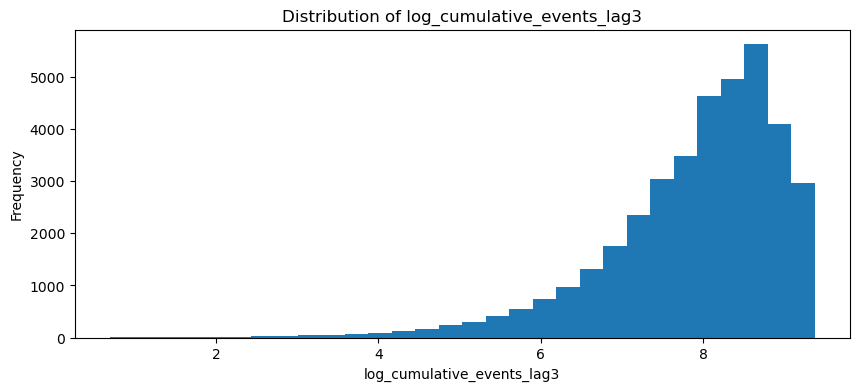

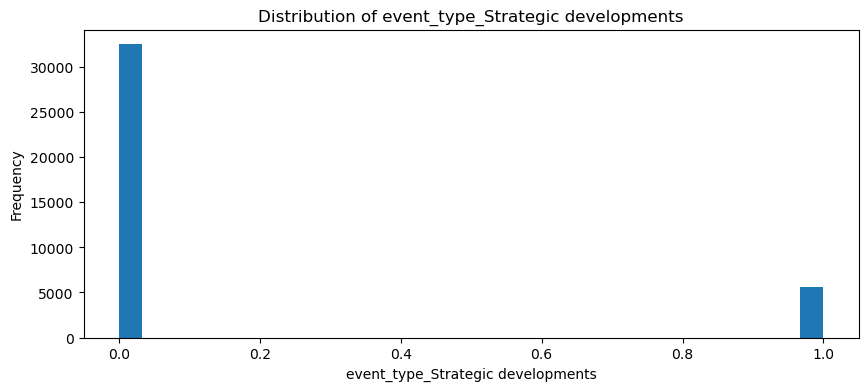

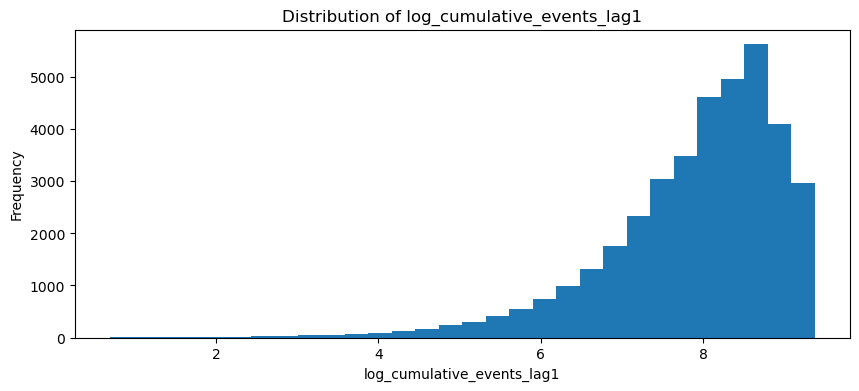

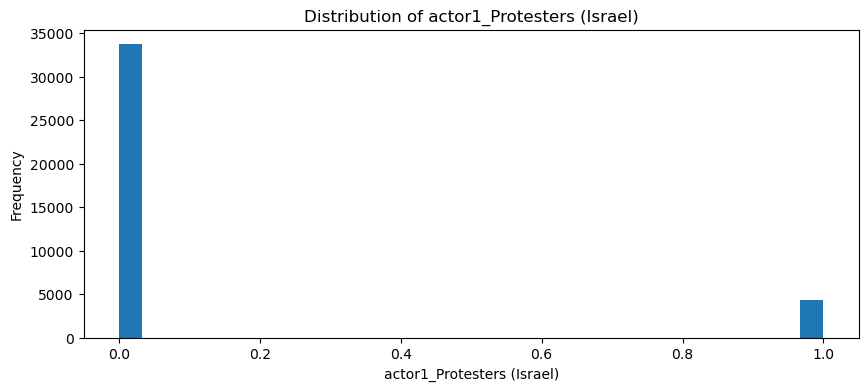

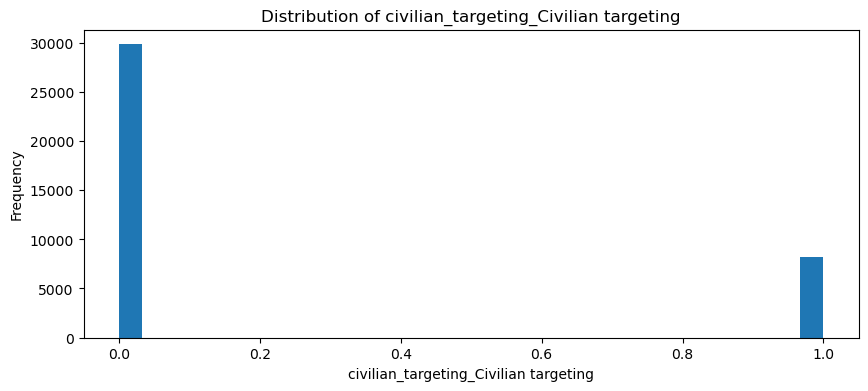

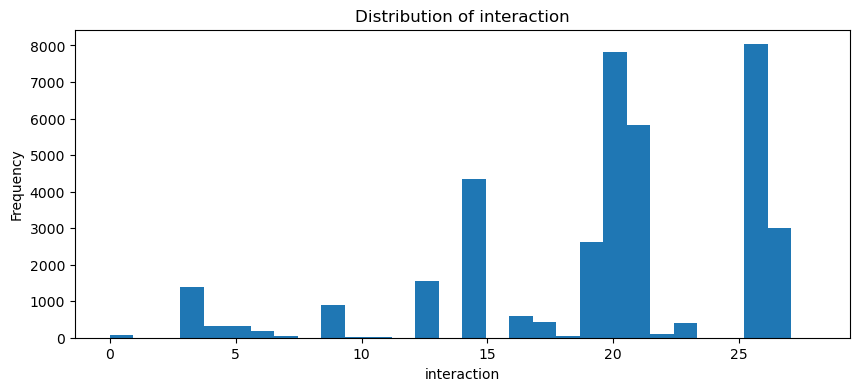

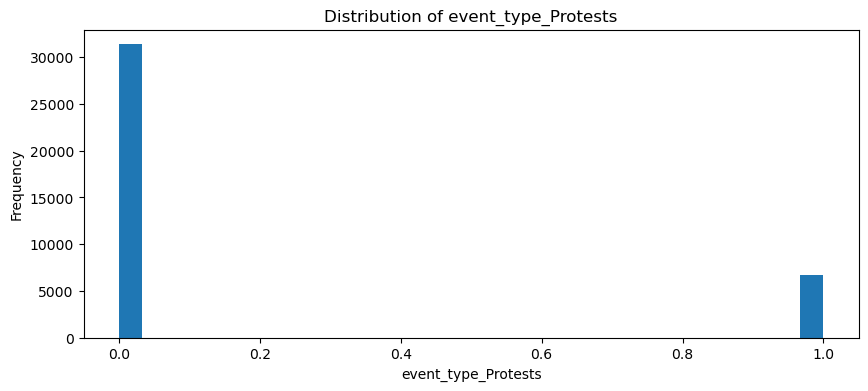

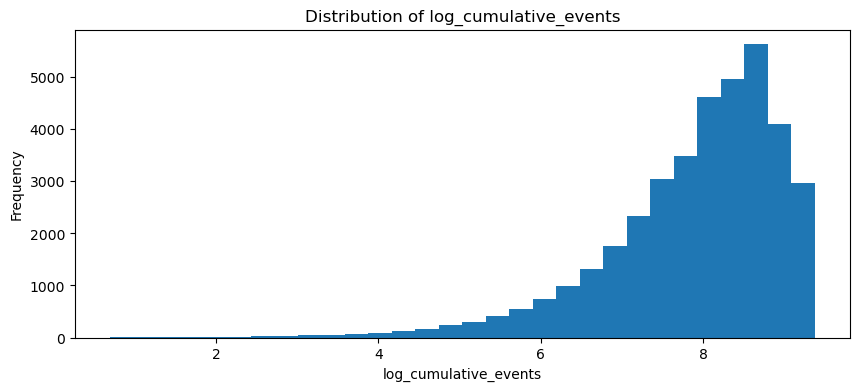

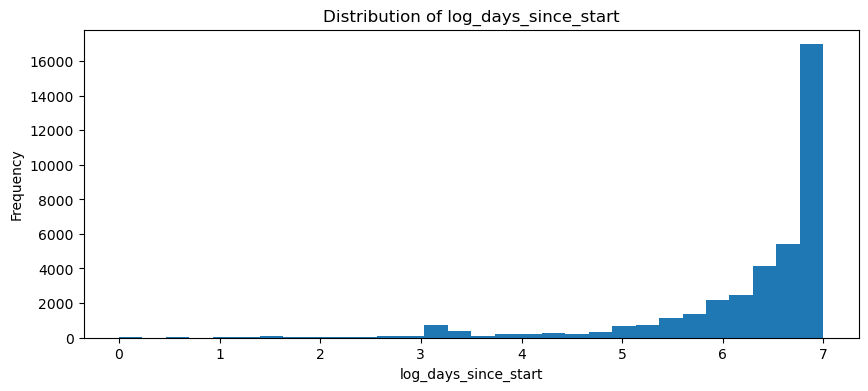

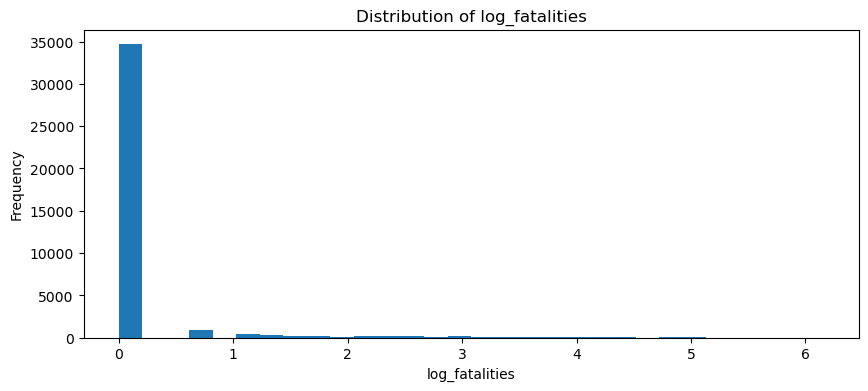

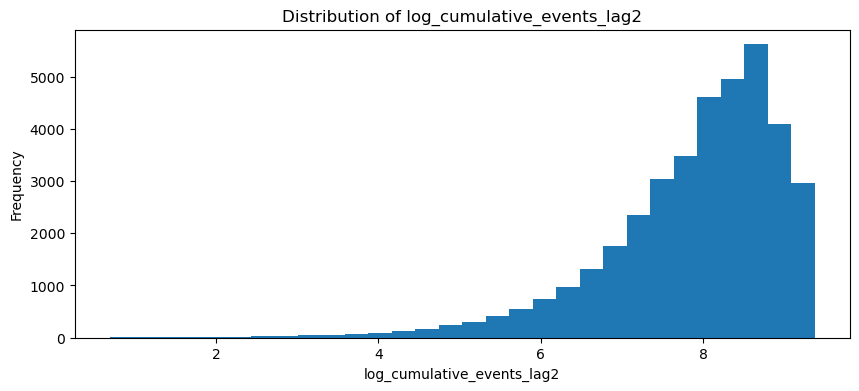

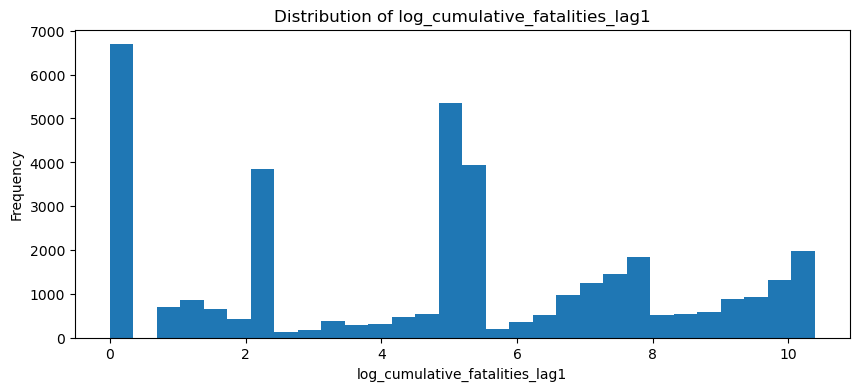

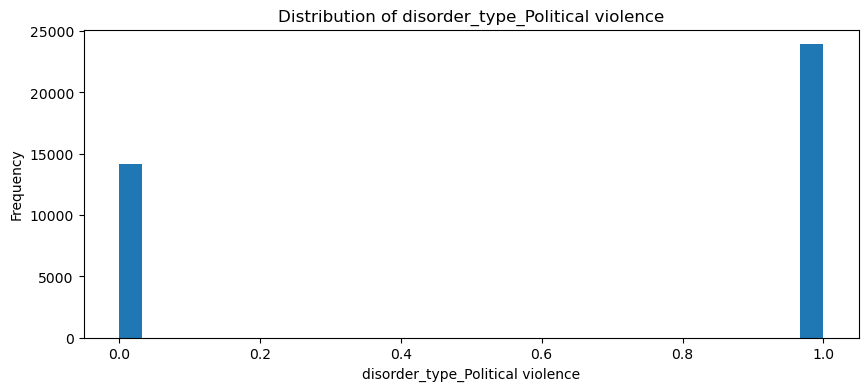

In [26]:
numeric_selected_features = [f for f in selected_features if pd.api.types.is_numeric_dtype(log_data_encoded[f])]
log_data_encoded = log_data_encoded.apply(lambda col: col.astype(int) if pd.api.types.is_bool_dtype(col) else col)

for feature in numeric_selected_features:
    plt.figure(figsize=(10, 4))
    plt.hist(log_data_encoded[feature], bins=30)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

In [27]:
#top_features_combined = pd.merge(top_mi_features, top_rf_features, on='Feature', how='inner')
#print(top_features_combined)
#top_features_combined.to_csv('data/top_features_combined.csv', index=False)

In [28]:
selected_features

['event_type_Battles',
 'log_days_since_start_lag3',
 'log_cumulative_fatalities_lag3',
 'days_since_start',
 'log_rolling_avg_fatalities_7d_lag1',
 'actor2_Not specified',
 'cumulative_fatalities',
 'admin1_Gaza Strip',
 'inter2',
 'event_type_Violence against civilians',
 'inter1',
 'actor1_Military Forces of Israel',
 'cumulative_events',
 'fatalities',
 'actor2_Military Forces of Israel',
 'actor1_Rioters (Palestine)',
 'log_rolling_avg_fatalities_7d',
 'log_days_since_start_lag2',
 'admin1_West Bank',
 'rolling_avg_fatalities_7d',
 'disorder_type_Demonstrations',
 'log_days_since_start_lag1',
 'event_type_Explosions/Remote violence',
 'country_Israel',
 'log_cumulative_fatalities_lag2',
 'event_type_Riots',
 'country_Palestine',
 'civilian_targeting_Not specified',
 'log_cumulative_fatalities',
 'disorder_type_Strategic developments',
 'actor2_Civilians (Palestine)',
 'log_cumulative_events_lag3',
 'event_type_Strategic developments',
 'log_cumulative_events_lag1',
 'actor1_Protes

In [29]:
#Selected Features
X_selected = log_data_encoded[selected_features]
y = log_data_encoded['sub_event_type']

X_selected_train, X_selected_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42
                                                                      , shuffle=False)

#REgular model minus text
X = log_data_encoded.drop(['sub_event_type', 'event_date', 'source', 'notes'], axis=1) # 'event_date', 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [30]:
y_test

30505    12
30506    12
30507     2
30508    18
30509    14
         ..
38125    14
38126    12
38127    15
38128    12
38129    11
Name: sub_event_type, Length: 7618, dtype: int64

In [31]:
def naive_forecast_last(train_data):
    return train_data.iloc[-1]

last_value = naive_forecast_last(y_train)  # Get the last value from the training target
predictions = [last_value] * len(y_test)  # Create a list of predictions for the test set

# Evaluate the prediction
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy of Naïve Forecast: {accuracy:.2f}")

Accuracy of Naïve Forecast: 0.02


In [32]:
def naive_forecast_last(train_data):
    return train_data.iloc[-1]

last_value = naive_forecast_last(y_train)  # Get the last value from the training target
predictions = [last_value] * len(y_test)  # Create a list of predictions for the test set

# Evaluate the prediction
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy of Naïve Forecast: {accuracy:.2f}")


Accuracy of Naïve Forecast: 0.02


In [33]:
#Decision Tree Selected 

tree_classifier = DecisionTreeClassifier(random_state=42)

tree_classifier.fit(X_selected_train, y_train)

tree_predictions = tree_classifier.predict(X_selected_test)

tree_accuracy = accuracy_score(y_test, tree_predictions)
tree_classification_report = classification_report(y_test, tree_predictions)
print(f"Accuracy of Decision Tree Selected: {tree_accuracy:.2f}")
print(tree_classification_report)

Accuracy of Decision Tree Selected: 0.93
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.67      0.21      0.32       152
           3       1.00      1.00      1.00       161
           4       0.10      0.07      0.08        14
           5       1.00      1.00      1.00       440
           6       0.85      0.83      0.84        64
           7       0.77      0.82      0.79        44
           8       1.00      1.00      1.00       108
          10       0.00      0.00      0.00         2
          11       0.92      0.45      0.61       564
          12       1.00      1.00      1.00      2720
          14       0.70      0.97      0.81       752
          15       1.00      1.00      1.00      1519
          16       1.00      0.99      1.00       281
          17       0.00      0.00      0.00         7
          18       0.51      0.81      0.63       163
          19       1.00      1.00      1

In [34]:
#Decision Tree Baseline
tree_classifier = DecisionTreeClassifier(random_state=42)

tree_classifier.fit(X_train, y_train)

tree_predictions = tree_classifier.predict(X_test)

tree_accuracy = accuracy_score(y_test, tree_predictions)
tree_classification_report = classification_report(y_test, tree_predictions)
print(f"Accuracy of Decision Tree Selected: {tree_accuracy:.2f}")
print(tree_classification_report)


Accuracy of Decision Tree Selected: 0.95
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         1
           2       0.80      0.72      0.76       152
           3       1.00      0.98      0.99       161
           4       0.20      0.14      0.17        14
           5       1.00      0.99      1.00       440
           6       0.85      0.83      0.84        64
           7       0.56      0.45      0.50        44
           8       0.98      0.93      0.95       108
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         2
          11       0.87      0.63      0.73       564
          12       1.00      1.00      1.00      2720
          14       0.77      0.96      0.85       752
          15       1.00      1.00      1.00      1519
          16       1.00      0.99      1.00       281
          17       0.20      0.29      0

/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(

In [35]:
# Logistic Regression Selected

logistic_regressor = LogisticRegression(max_iter=1000, random_state=42)

logistic_regressor.fit(X_train, y_train)

logistic_predictions = logistic_regressor.predict(X_test)

logistic_accuracy = accuracy_score(y_test, logistic_predictions)
logistic_classification_report = classification_report(y_test, logistic_predictions)

print(f"Accuracy of Logistic Regression Baseline: {logistic_accuracy:.2f}")
print(logistic_classification_report)

Accuracy of Logistic Regression Baseline: 0.36
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00       152
           3       0.00      0.00      0.00       161
           4       0.00      0.00      0.00        14
           5       0.91      1.00      0.95       440
           6       0.00      0.00      0.00        64
           7       0.00      0.00      0.00        44
           8       0.00      0.00      0.00       108
          10       0.00      0.00      0.00         2
          11       0.00      0.00      0.00       564
          12       0.90      0.33      0.49      2720
          13       0.00      0.00      0.00         0
          14       0.28      1.00      0.44       752
          15       0.93      0.43      0.58      1519
          16       0.00      0.00      0.00       281
          17       0.02      1.00      0.04         7
          18       0.00      0.00 

/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetric

In [36]:
# Logistic Regression Baseline

logistic_regressor = LogisticRegression(max_iter=1000, random_state=42)

logistic_regressor.fit(X_selected_train, y_train)

logistic_predictions = logistic_regressor.predict(X_selected_test)

logistic_accuracy = accuracy_score(y_test, logistic_predictions)
logistic_classification_report = classification_report(y_test, logistic_predictions)

print(f"Accuracy of Logistic Regression Baseline: {logistic_accuracy:.2f}")
print(logistic_classification_report)

Accuracy of Logistic Regression Baseline: 0.65
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         1
           2       0.37      0.05      0.08       152
           3       0.17      0.41      0.24       161
           4       0.00      0.00      0.00        14
           5       0.00      0.00      0.00       440
           6       0.00      0.00      0.00        64
           7       0.00      0.00      0.00        44
           8       0.00      0.00      0.00       108
          10       0.00      0.00      0.00         2
          11       0.00      0.00      0.00       564
          12       0.81      1.00      0.90      2720
          14       0.41      1.00      0.59       752
          15       0.90      0.90      0.90      1519
          16       0.00      0.00      0.00       281
          17       0.02      0.86      0.04         7
          18       0.00      0.00 

/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetric

In [37]:
numeric_log_data = log_data_encoded.drop(columns=[target,'source', 'notes'])
#def test_stationarity(series):
    #result = adfuller(series.dropna(), autolag='AIC') 
    #return {"Test Statistic": result[0], "p-value": result[1], "Critical Values": result[4]}

In [38]:
#results = {column: test_stationarity(numeric_log_data[column]) for column in numeric_log_data.columns}

#results


In [39]:
# differencing to 'year', 'month', and 'days_since_start'
#numeric_log_data['year_diff'] = numeric_log_data['year'].diff()
#numeric_log_data['month_diff'] = numeric_log_data['month'].diff()
#numeric_log_data['days_since_start_diff'] = numeric_log_data['days_since_start'].diff()

#data = data.dropna(subset=['year_diff', 'month_diff', 'days_since_start_diff'])

# testing stationarity after differencing
#new = {
#    'year_diff': test_stationarity(numeric_log_data['year_diff']),
#    'month_diff': test_stationarity(numeric_log_data['month_diff']),
#    'days_since_start_diff': test_stationarity(numeric_log_data['days_since_start_diff'])}

#new


Everything is now stationary

In [40]:
X_train.dtypes

year                     int32
inter1                   int64
inter2                   int64
interaction              int64
fatalities               int64
                         ...  
day_of_week_Saturday     int64
day_of_week_Sunday       int64
day_of_week_Thursday     int64
day_of_week_Tuesday      int64
day_of_week_Wednesday    int64
Length: 151, dtype: object

In [50]:
X_selected = log_data_encoded[selected_features]
y = log_data_encoded['sub_event_type']


X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, shuffle=False)

In [51]:
# converting to categorical
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_test_encoded = tf.keras.utils.to_categorical(y_test)

#  LSTM model
model = Sequential()
model.add(Embedding(input_dim=len(np.unique(y)), output_dim=100, input_length=X_train.shape[1]))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(y_train_encoded.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model.fit(X_train, y_train_encoded, epochs=25, batch_size=32, validation_split=0.1)

#eval
loss, accuracy = model.evaluate(X_test, y_test_encoded)
print(f'Test Accuracy: {accuracy:.2f}')


Epoch 1/25


2024-04-28 03:34:48.577719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 03:34:48.777686: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 03:34:48.905447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 03:34:49.060597: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/857 [..............................] - ETA: 21:31 - loss: 2.9967 - accuracy: 0.0938

2024-04-28 03:34:49.261976: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


855/857 [============================>.] - ETA: 0s - loss: 1.0196 - accuracy: 0.6677

2024-04-28 03:35:10.111709: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 03:35:10.185491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 03:35:10.274450: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


857/857 [==============================] - 24s 26ms/step - loss: 1.0179 - accuracy: 0.6682 - val_loss: 0.2980 - val_accuracy: 0.9314
Epoch 2/25
857/857 [==============================] - 20s 24ms/step - loss: 0.3169 - accuracy: 0.8884 - val_loss: 0.1688 - val_accuracy: 0.9485
Epoch 3/25
857/857 [==============================] - 20s 24ms/step - loss: 0.2470 - accuracy: 0.9100 - val_loss: 0.1036 - val_accuracy: 0.9711
Epoch 4/25
857/857 [==============================] - 21s 25ms/step - loss: 0.2268 - accuracy: 0.9161 - val_loss: 0.1396 - val_accuracy: 0.9596
Epoch 5/25
857/857 [==============================] - 20s 23ms/step - loss: 0.2133 - accuracy: 0.9190 - val_loss: 0.1085 - val_accuracy: 0.9685
Epoch 6/25
857/857 [==============================] - 21s 24ms/step - loss: 0.2061 - accuracy: 0.9204 - val_loss: 0.0857 - val_accuracy: 0.9747
Epoch 7/25
857/857 [==============================] - 20s 23ms/step - loss: 0.2039 - accuracy: 0.9217 - val_loss: 0.0845 - val_accuracy: 0.9741
Epo

In [57]:
# predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # convert probabilities to class labels

actual_classes = np.argmax(y_test_encoded, axis=1) if y_test_encoded.ndim > 1 else y_test
errors = np.where(y_pred_classes != actual_classes)[0]
print(f'Number of errors: {len(errors)} / {len(actual_classes)}')

# errors
for i in errors[:10]:  # first 10 
    print(f'Index: {i}, Predicted: {y_pred_classes[i]}, Actual: {actual_classes[i]}')

# Calculate metrics
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')
#conf_matrix = confusion_matrix(y_test, y_pred_classes)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print("Confusion Matrix:")
#print(conf_matrix)

239/239 [==============================] - 1s 5ms/step
Number of errors: 1188 / 7618
Index: 2, Predicted: 18, Actual: 2
Index: 8, Predicted: 18, Actual: 2
Index: 9, Predicted: 18, Actual: 12
Index: 19, Predicted: 18, Actual: 2
Index: 20, Predicted: 18, Actual: 12
Index: 31, Predicted: 18, Actual: 12
Index: 33, Predicted: 18, Actual: 12
Index: 43, Predicted: 18, Actual: 12
Index: 51, Predicted: 18, Actual: 12
Index: 54, Predicted: 18, Actual: 12
Precision: 0.93
Recall: 0.84
F1-Score: 0.87
Confusion Matrix:


/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(

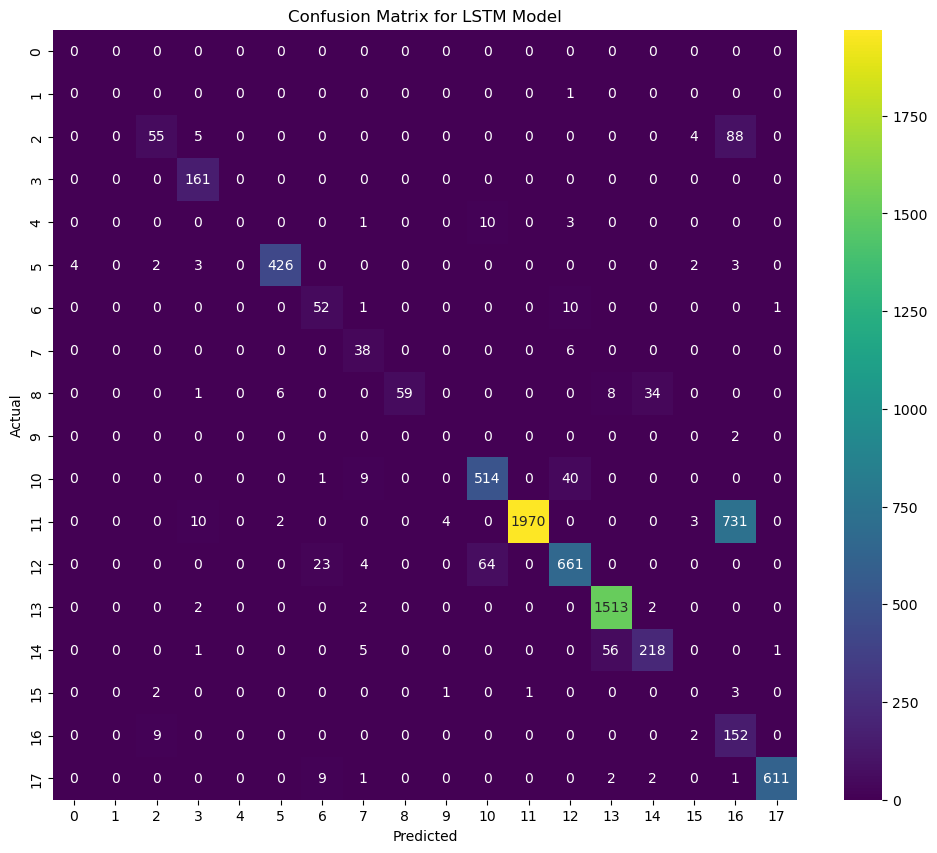

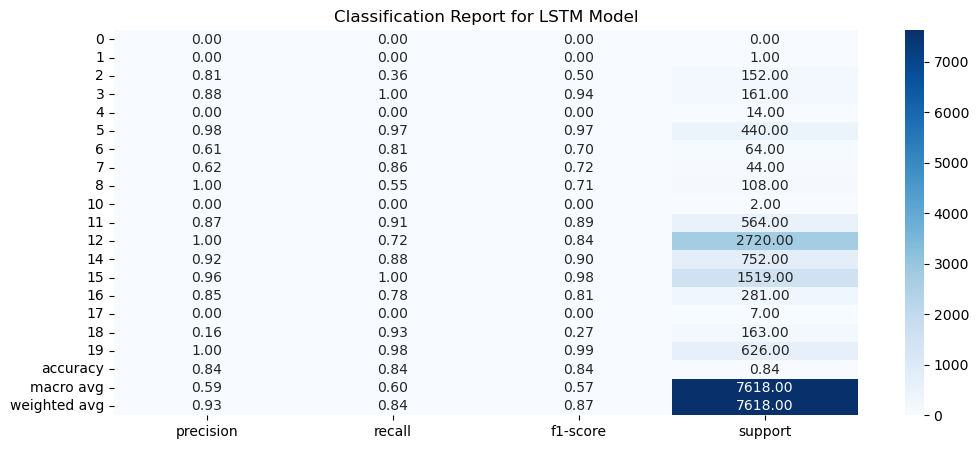

In [58]:
# Generating a classification report
report = classification_report(actual_classes, y_pred_classes, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Plotting the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='viridis')
plt.title('Confusion Matrix for LSTM Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plotting the classification report metrics
plt.figure(figsize=(12, 5))
sns.heatmap(pd.DataFrame(report_df), annot=True, fmt='.2f', cmap='Blues')
plt.title('Classification Report for LSTM Model')
plt.show()

In [59]:
predicted_labels = label_encoders['sub_event_type'].inverse_transform(y_pred_classes)

actual_labels = label_encoders['sub_event_type'].inverse_transform(y_test)

for actual, predicted in zip(actual_labels[:10], predicted_labels[:10]):
    print(f"Actual: {actual}, Predicted: {predicted}")


Actual: Mob violence, Predicted: Mob violence
Actual: Mob violence, Predicted: Mob violence
Actual: Air/drone strike, Predicted: Shelling/artillery/missile attack
Actual: Shelling/artillery/missile attack, Predicted: Shelling/artillery/missile attack
Actual: Other, Predicted: Other
Actual: Other, Predicted: Other
Actual: Mob violence, Predicted: Mob violence
Actual: Mob violence, Predicted: Mob violence
Actual: Air/drone strike, Predicted: Shelling/artillery/missile attack
Actual: Mob violence, Predicted: Shelling/artillery/missile attack


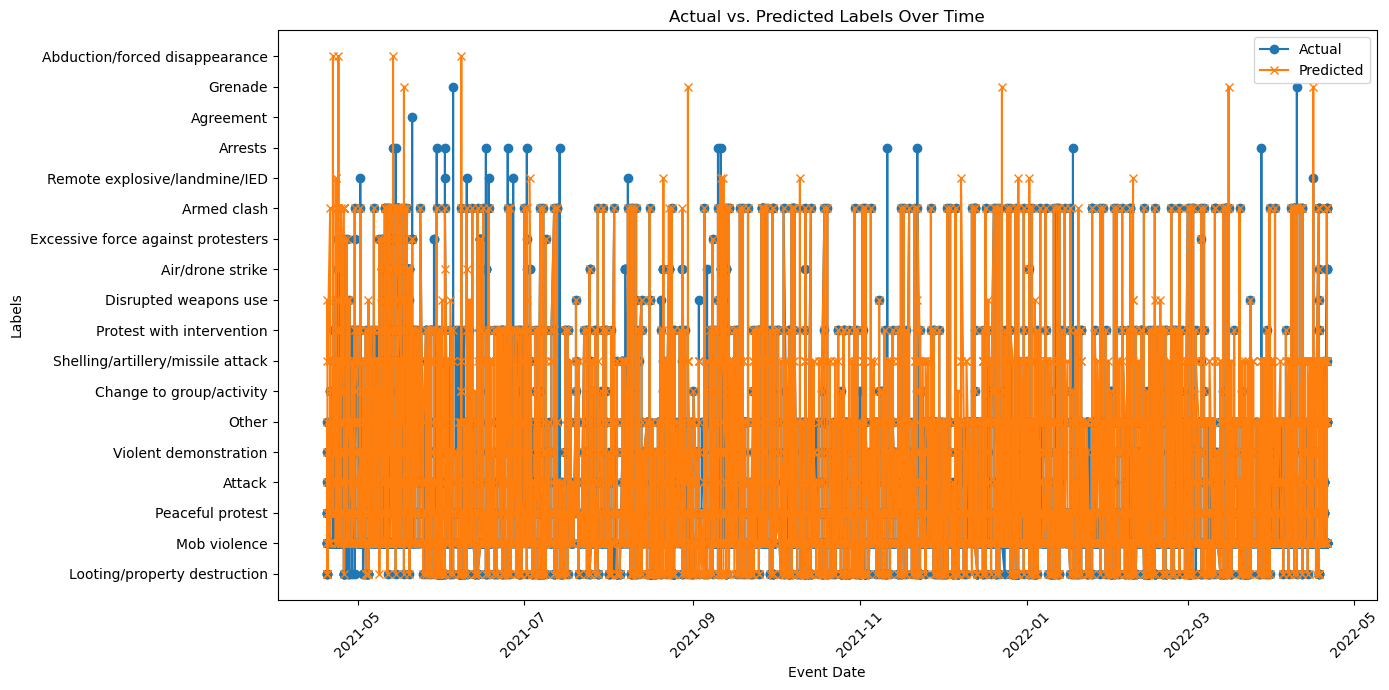

In [60]:
#Time-series plot?
event_dates_test = data.loc[X_test.index, 'event_date']


results_df = pd.DataFrame({
    'event_date': event_dates_test,
    'actual_labels': label_encoders['sub_event_type'].inverse_transform(y_test),
    'predicted_labels': label_encoders['sub_event_type'].inverse_transform(y_pred_classes)
})

results_df.sort_values('event_date', inplace=True)

plt.figure(figsize=(14, 7))
plt.plot(results_df['event_date'], results_df['actual_labels'], label='Actual', marker='o')
plt.plot(results_df['event_date'], results_df['predicted_labels'], label='Predicted', marker='x')
plt.title('Actual vs. Predicted Labels Over Time')
plt.xlabel('Event Date')
plt.ylabel('Labels')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
#X_selected = log_data_encoded[selected_features]
#y = log_data_encoded['sub_event_type']


#X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, shuffle=False)

In [71]:
X = log_data_encoded[selected_features] #log_data_encoded.drop(['sub_event_type', 'event_date', 'source', 'notes'], axis=1)
y_encoded = to_categorical(log_data_encoded['sub_event_type'])


#model
def create_model(input_length, num_classes):
    model = Sequential()
    model.add(Embedding(input_dim=num_classes, output_dim=100, input_length=input_length))
    model.add(LSTM(50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# CV
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores, cv_precision, cv_recall, cv_f1 = [], [], [], []

2024-04-28 05:20:01.702708: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 05:20:02.015194: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 05:20:02.178112: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 05:20:02.399911: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 05:20:02.648239: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 05:23:59.310894: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 05:23:59.410189: I tensorflow/core/grappler/optimizers/cust

239/239 [==============================] - 2s 6ms/step


/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


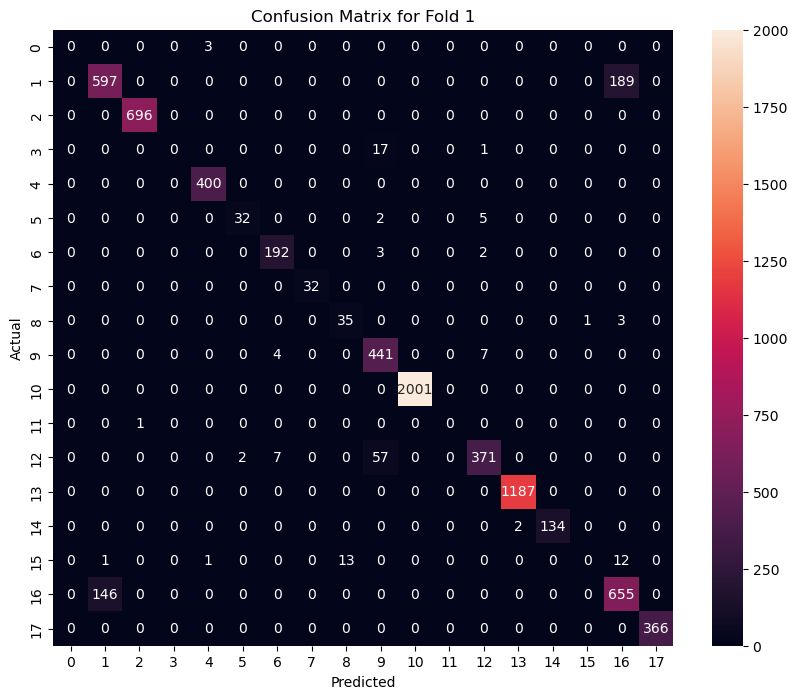

/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

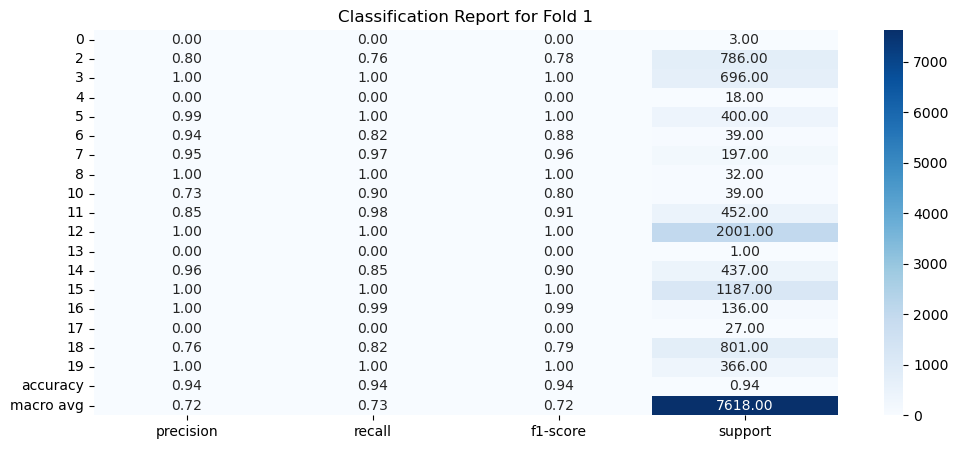

2024-04-28 05:24:06.528554: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 05:24:06.710478: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 05:24:06.842461: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 05:24:07.109092: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 05:24:07.381225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 05:28:02.180445: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 05:28:02.283544: I tensorflow/core/grappler/optimizers/cust

239/239 [==============================] - 2s 6ms/step


/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


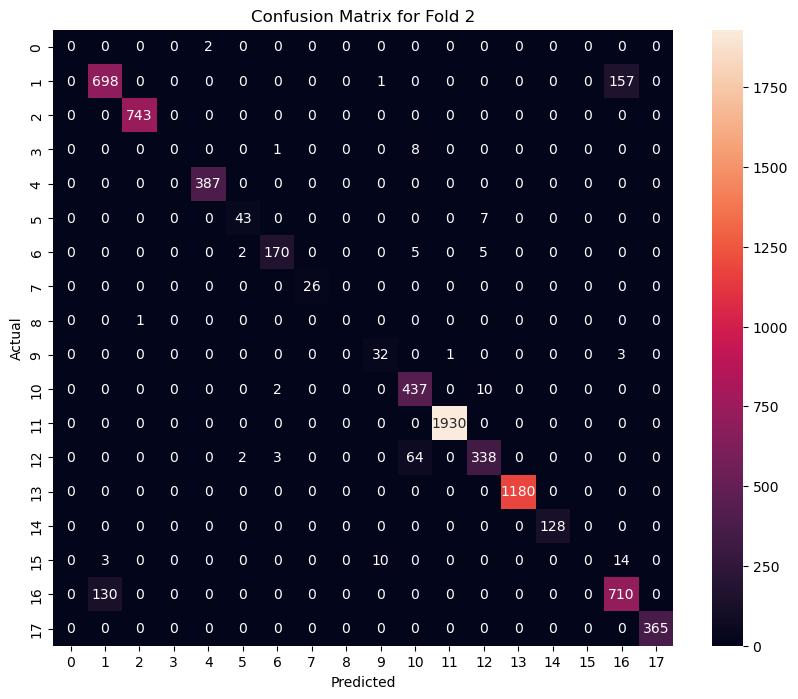

/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

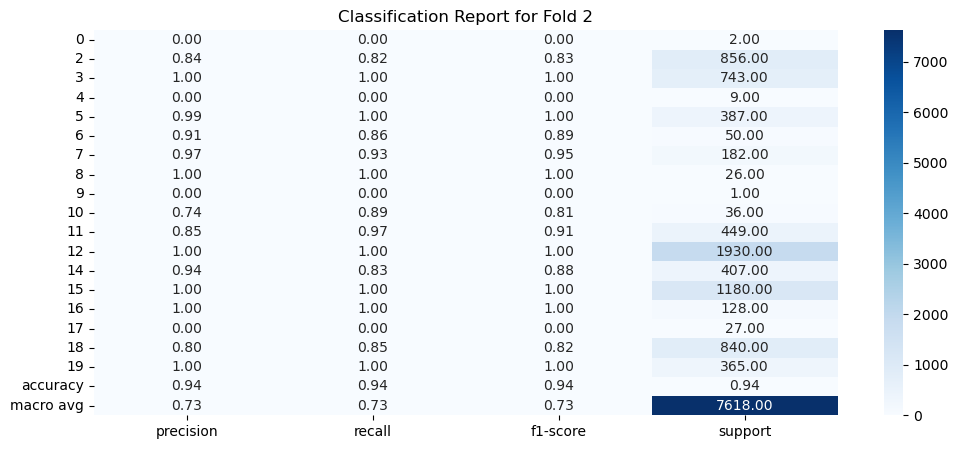

2024-04-28 05:28:10.031296: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 05:28:10.270344: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 05:28:10.451668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 05:28:10.692738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 05:28:10.903331: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 05:32:06.529066: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 05:32:06.604882: I tensorflow/core/grappler/optimizers/cust

  6/239 [..............................] - ETA: 2s  

2024-04-28 05:32:11.024904: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


239/239 [==============================] - 2s 6ms/step


/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


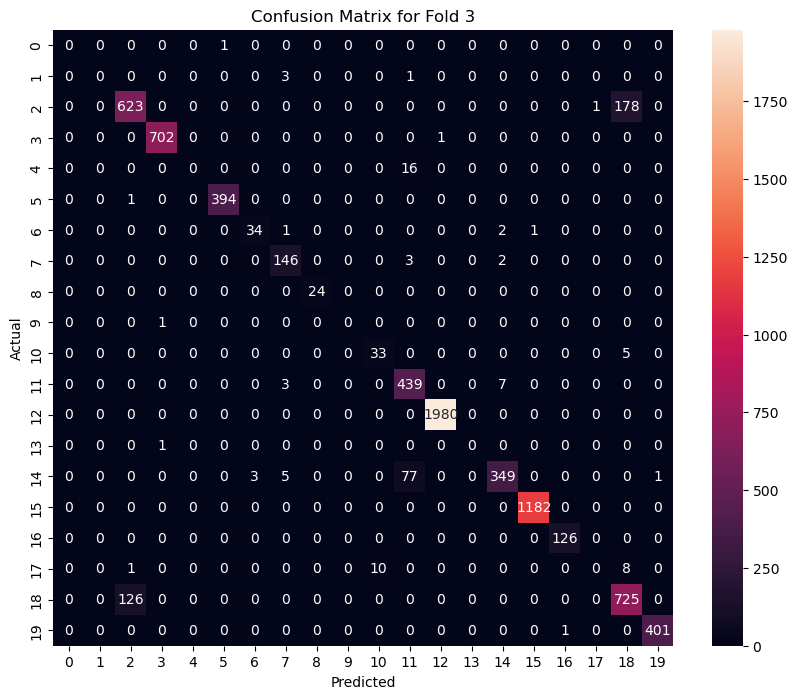

/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

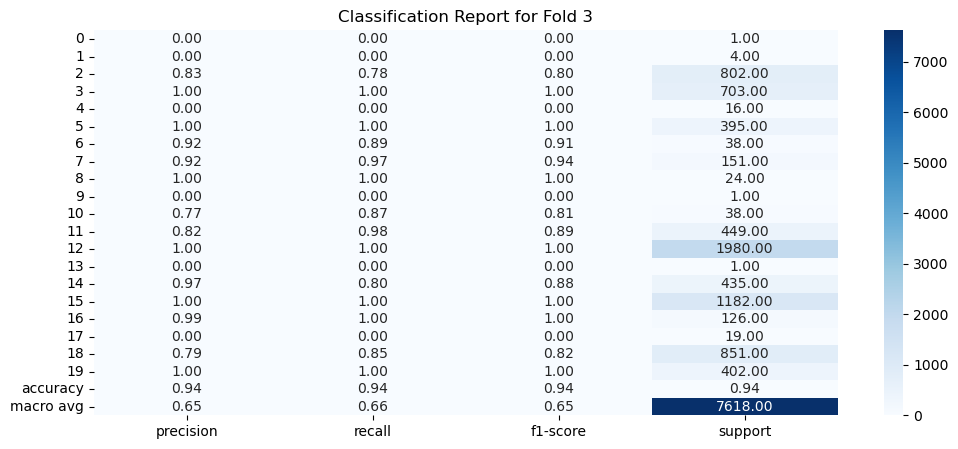

2024-04-28 05:32:14.494624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 05:32:14.702743: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 05:32:14.909269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 05:32:15.195730: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 05:32:15.477043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 05:36:16.694093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 05:36:16.777933: I tensorflow/core/grappler/optimizers/cust

239/239 [==============================] - 2s 6ms/step


/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


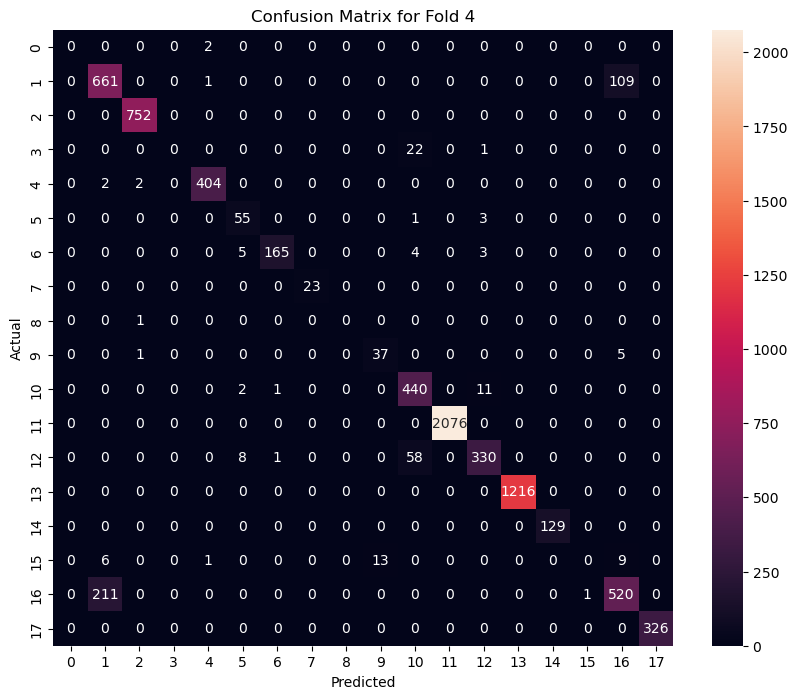

/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

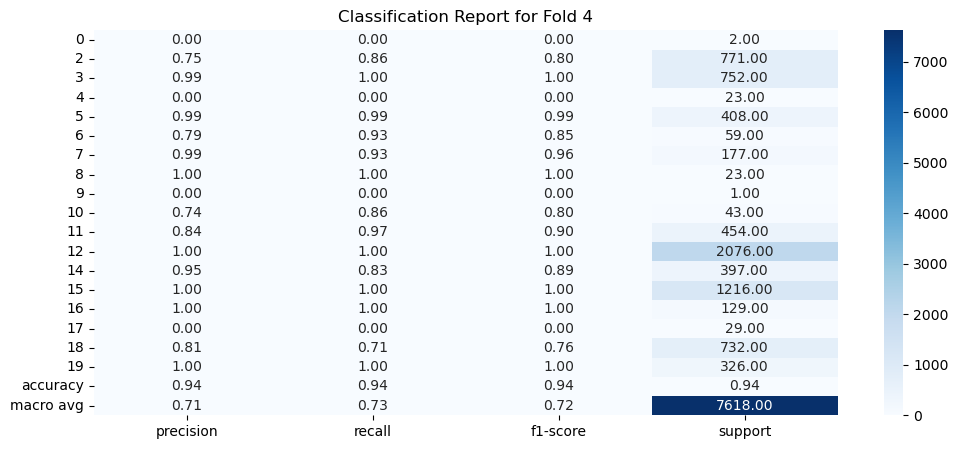

2024-04-28 05:36:24.300777: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 05:36:24.539948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 05:36:24.730654: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 05:36:25.002029: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 05:36:25.307901: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 05:40:27.992173: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 05:40:28.076044: I tensorflow/core/grappler/optimizers/cust

  1/239 [..............................] - ETA: 2:12

2024-04-28 05:40:33.408515: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


239/239 [==============================] - 2s 6ms/step


/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


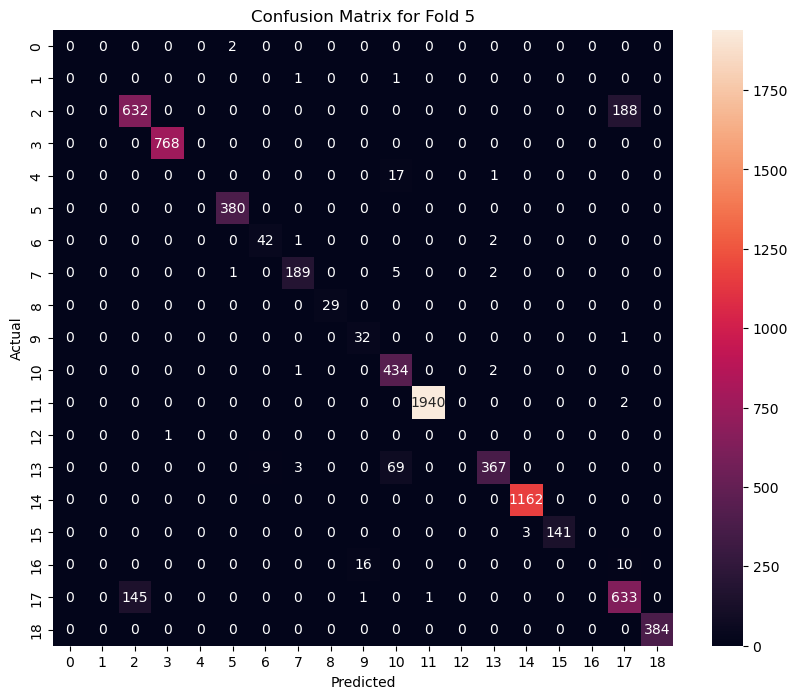

/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

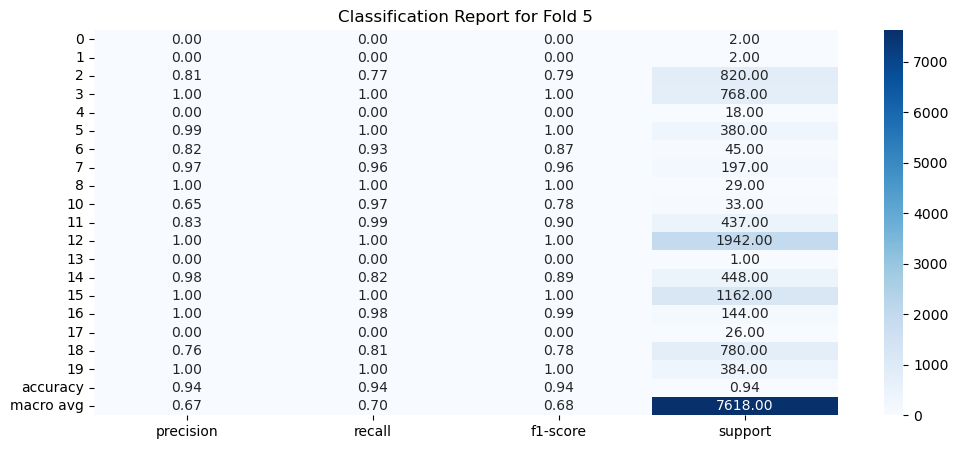

In [77]:
X_reset = X.reset_index(drop=True)
all_labels = np.unique(np.concatenate([y, np.argmax(y_encoded, axis=1)]))
label_encoders['sub_event_type'].fit(all_labels)

for fold, (train, test) in enumerate(kfold.split(X_reset, y_encoded), 1):
#make model
    model = create_model(X_reset.shape[1], y_encoded.shape[1])
    model.fit(X_reset.iloc[train], y_encoded[train], epochs=10, batch_size=32, verbose=0) 
    
#eval
    scores = model.evaluate(X_reset.iloc[test], y_encoded[test], verbose=0)
    cv_scores.append(scores[1])
    
# predicts + transform into og labels
    y_pred = model.predict(X_reset.iloc[test])
    y_pred_classes = np.argmax(y_pred, axis=1)

    y_pred_labels = label_encoders['sub_event_type'].inverse_transform(y_pred_classes)
    y_actual_labels = label_encoders['sub_event_type'].inverse_transform(np.argmax(y_encoded[test], axis=1))
    
# metrics
    precision = precision_score(y_actual_labels, y_pred_labels, average='weighted')
    recall = recall_score(y_actual_labels, y_pred_labels, average='weighted')
    f1 = f1_score(y_actual_labels, y_pred_labels, average='weighted')
    cv_precision.append(precision)
    cv_recall.append(recall)
    cv_f1.append(f1)

# Confusion matrix
    conf_matrix = confusion_matrix(y_actual_labels, y_pred_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d')
    plt.title(f'Confusion Matrix for Fold {fold}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

#classification report
    y_test_actual = label_encoders['sub_event_type'].inverse_transform(np.argmax(y_encoded[test], axis=1))
    y_pred_actual = label_encoders['sub_event_type'].inverse_transform(y_pred_classes)
    
    unique_labels_actual = np.unique(np.concatenate([y_test_actual, y_pred_actual]))
    
    report = classification_report(
        y_test_actual,
        y_pred_actual,
        labels=unique_labels_actual,
        target_names=unique_labels_actual,
        output_dict=True
    )
    
    report_df = pd.DataFrame(report).transpose()
    plt.figure(figsize=(12, 5))
    sns.heatmap(report_df.iloc[:-1, :].astype(float), annot=True, fmt=".2f", cmap='Blues')
    plt.title(f'Classification Report for Fold {fold}')
    plt.show()

In [80]:
print(f'Mean Accuracy: {np.mean(cv_scores):.2f}, Standard Deviation: {np.std(cv_scores):.2f}')
print(f'Mean Precision: {np.mean(cv_precision):.2f}, \
Mean Recall: {np.mean(cv_recall):.2f}, \
Mean F1-Score: {np.mean(cv_f1):.2f}')

Mean Accuracy: 0.94, Standard Deviation: 0.00
Mean Precision: 0.93, Mean Recall: 0.94, Mean F1-Score: 0.94
